# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### 1. Изучим общую информацию. 

### Подготовка к исследованию

**1) Общее описание столбцов**

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

**2) Создадим объект "Исследователь данных", который соберет качестве методов:**
    - постороение графиков,
    - подстветку ячеек в таблице,
    - трансформацию значений в столбце,
    - конвертор в ДатаФрейм,
    - вывод изолированного столбца с коэффициентами корреляции,
    - метрику SMAPE.

- Объявляем класс DataExplorer и наполянем его методами

In [1]:
class DataExplorer:
    
    def histogram(self, data, n_bins, range_start, range_end, cumulative=False, x_label = "", y_label = "", title = ""):
        # Создаем объект - график
        _, ax = plt.subplots()

        # Задаем параметры
        ax.hist(data, bins = n_bins, range = (range_start, range_end), cumulative = cumulative, color = '#4169E1')

        # Добавляем сетку
        ax.grid(color='grey', linestyle='-', linewidth=0.5)

        # Добавляем медиану
        ax.axvline(data.median(),linestyle = '--', color = '#FF1493')
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        
    def scatterplot(self, x_data, y_data, x_label="", y_label="", title="", color = "r", yscale_log=False, figsize = (8, 6)):

        # Создаем объект - график
        _, ax = plt.subplots(figsize = (8, 6))

        # Задаем параметры для графика, определяем размер (s), цвет и прозрачность точек на графике
        ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)

        if yscale_log == True:
            ax.set_yscale('log')

        # Создаем описание осей и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
    def overlaid_histogram(self, data1, data2, n_bins = 0, data1_name="", data1_color="#539caf", data2_name="", data2_color="#7663b0", x_label="", y_label="", title=""):
        # Устанавливаем границы для корзин так чтобы оба распределения на графике были соотносимы
        max_nbins = 10
        data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
        binwidth = (data_range[1] - data_range[0]) / max_nbins


        if n_bins == 0:
            bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)
        else: 
            bins = n_bins

        # Рисуем график
        _, ax = plt.subplots()
        ax.hist(data1, bins = bins, color = data1_color, alpha = 1, label = data1_name)
        ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, label = data2_name)
        ax.set_ylabel(y_label)
        ax.set_xlabel(x_label)
        ax.set_title(title)
        ax.legend(loc = 'best')
        
    def corr_diagram(self, x):
        plt.figure(figsize=(12,10), dpi= 80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0, annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()
        
    def highlight_max(self, data, color='yellow'):
        '''
        highlight the maximum in a Series or DataFrame
        '''
        attr = 'background-color: {}'.format(color)
        #remove % and cast to float
        data = data.replace('%','', regex=True).astype(float)
        data[data == 1] = None
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = (data == data.abs().max()) & (data !=1) 
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = (data == data.abs().max()) & (data !=1) 
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)
    
    def highlight_sorted_corr(self, data, color='#00FF00'):
        '''
        highlight the maximum in a Series or DataFrame
        '''
        attr = 'background-color: {}'.format(color)
        #remove % and cast to float
        data = data.replace('%','', regex=True).astype(float)
        data[data == 1] = None
        if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
            is_max = (data > 0.1) & (data !=1) 
            return [attr if v else '' for v in is_max]
        else:  # from .apply(axis=None)
            is_max = (data == data.abs().max()) & (data !=1) 
            return pd.DataFrame(np.where(is_max, attr, ''),
                                index=data.index, columns=data.columns)
        
    def lineplot(self, x_data, y_data, x_label="", y_label="", title=""):
        # Создаем объект - график
        _, ax = plt.subplots()

        # Задаем параметры для линии: ширину (lw), цвет и прозрачность (alpha)
        ax.plot(x_data, y_data, lw = 2, color = '#539caf', alpha = 1)

        # Даем имена осям и заголовок для графика
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
    
        
    def hexbin(self, data, x, y):
        data.plot(x = x, y = y, kind='hexbin', gridsize=20, figsize=(8, 6), sharex=False, grid=True)
        
        
    def bar_plotter(self, data):
        data.plot.bar(rot=0, figsize = (16, 5))
        
        
    def pandahug(self, some_stuff):
        return pd.DataFrame(some_stuff)
    
        
    def sorted_corr(self, data, attr):
        correlated = pd.DataFrame(data.corr()[attr].sort_values(ascending = False))
        return correlated    
    
    
    def transformer(self, data, name, grouper, func):
        """
        data - датасет
        name - столбец в котором меняем значения
        grouper - столбец по которому группируем
        func - пременяемая функция mean, median и т.д.
        """
        name = name
        data.loc[data[name].isnull(), name] = data.groupby(grouper)[name].transform(func)
        
    def smape(self, y_test, y_predict): 
        y_test, y_predict = np.array(y_test), np.array(y_predict)
        return np.mean((np.abs((y_predict - y_test)) / np.mean(np.abs(y_test) + np.abs(y_predict))) * 100)
    
    def mape(self, y_test, y_predict): 
        y_test, y_predict = np.array(y_test), np.array(y_predict)
        return np.median((np.abs((y_test - y_predict)) / y_test) * 100)

In [2]:
explorer = DataExplorer()

### 2. Импортируем библиотеки

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from matplotlib import dates
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr

### 3. Читаем таблицу в переменную df

In [4]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

### 4. Выведем первые пять строк полученной таблицы с помощью метода head(), а также еще пять случайных строк с помощью метода sample()

In [5]:
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [6]:
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
15668,7,2890000.0,31.3,2017-02-10T00:00:00,1,2.5,5.0,17.3,2,NaN,...,5.6,0.0,Санкт-Петербург,39840.0,11131.0,1.0,761.0,1.0,976.0,33.0
9112,5,3300000.0,44.0,2018-02-01T00:00:00,2,2.5,9.0,26.5,3,NaN,...,6.4,NaN,Санкт-Петербург,19002.0,18004.0,0.0,NaN,1.0,246.0,15.0
21793,5,6500000.0,64.0,2018-02-01T00:00:00,3,2.5,14.0,40.5,10,NaN,...,10.0,2.0,Санкт-Петербург,12324.0,10939.0,0.0,NaN,1.0,627.0,21.0
23612,2,3150000.0,41.0,2018-10-25T00:00:00,1,NaN,20.0,18.6,7,NaN,...,8.8,NaN,посёлок Шушары,12526.0,18312.0,0.0,NaN,0.0,NaN,43.0
17309,8,3750000.0,31.0,2019-02-22T00:00:00,1,2.5,9.0,15.6,7,NaN,...,8.3,NaN,Санкт-Петербург,42966.0,15470.0,0.0,NaN,0.0,NaN,23.0


В датасете 22 столбца, которые не влезают на экран. Выведем столбцы с помощью метода columns:

In [7]:
pd.set_option('display.max_columns',100)

In [8]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

При выводе не отобразились 'studio', 'open_plan' - исходя из описания датасета - сведения о том, является ли квартира студией и является ли планировка свободной.

**Предварительные выводы на основе первого визуального ознакомления**:
- в датасете 22 столбца,
- в таблице не требуется переименовывать заголовки, но для удобства нужно будет привести написание к одному регистру,
- есть множественные пропуски,
- столбец locality_name - потенциальный кандидат для цифрового кодирования, 
- за исключением столбцов total_images, rooms, floor цифровые данные представлены в вещественных числах; потребуется оценить необходимость сохранения вещественного типа данных для столбцов: last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition,
- first_day_exposition будет конертирована в дату,
- строчные данные в таблице внесены в разном регистре, но, в данном случае, это может быть не критично.

Столбцы с расстояниями до различных объектов представляет особый интерес, поскольку за счет повторяющихся значений позволит определять, как минимум, район в котором продается квартира: параметр, который будет очень полезен в предсказании цены на квартиру.

### 5. Получим общую информацию о таблице с помощью метода info()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

**В датасете 23 699 строк. Пропусков много, в 14 из 22 столбцов:** 
- неожиданно существенные пропуски в столбцах с расстояниями от центра (5519), прудов (14 589) и парков (15 620), информации о высоте потолков (9 195), количестве балконов (11 519), и статусе недвижимости - is_apartment (20 924),
- пропуски в столбцах с расстояниями до различных объектов очень критичны, поскольку получены автоматически и исходя из количества пропусков будет трудно восстановить их на основе других столбцов,
- пропуски в в столбцах с расстояниями до различных объектов вероятно говорят о том, что есть системная ошибка в формировании данных,
- информация о характеристиках квартир, скорее всего, будет восполнена статистическими методами,
- is_apartment и balcony - представляются самым простым для восполнения: is_apartment включают в себя булев тип данных, и пропуски, вероятно, вызваны отрицательным ответом на вопрос о типе помещения; balcony - пропуск, равно как значение "0" - вероятно, означают, отсутствие балконов.
- скорее всего, в датасете есть и другие неявные пропуски - ячейки, заполенные плейсхолдерами.

### 6. Получим дополнительные сведения о данных в таблице с помошью метода describe() и corr(): каков диапазон значений в данных, какова корреляция между парами наблюдений

Для удобства исследования вызовем describe() с транспортированием

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


Изучим значения по категориальным признакам

In [11]:
df.describe(include=['object']).T

,count,unique,top,freq
first_day_exposition,23699,1491,2018-02-01T00:00:00,368
is_apartment,2775,2,False,2725
locality_name,23650,364,Санкт-Петербург,15721


**Выводы:**
- в колонках есть бессмысленные наблюдения: например, ноль комнат, стометровая высота потолков (и высота в один метр); что-то из таких показателей - технические пропуски, а что-то является ошибкой,
- максимальная стоимость квартиры - 763 миллиона рублей, максимальная площадь квартиры в датасете - 900 квадратных метров :).

**Проверим какие из наблюдений взаимосвязаны и взаимозаисимы между собой в том виде, каком они представлены сейчас с помощью метода corr().**

In [12]:
explorer.sorted_corr(df, 'last_price').style.apply(explorer.highlight_sorted_corr)

,last_price
last_price,1
total_area,0.653675
living_area,0.566492
kitchen_area,0.519869
rooms,0.363343
ponds_around3000,0.159996
parks_around3000,0.151058
total_images,0.104473
ceiling_height,0.0854303
days_exposition,0.0811459


**Выводы**:
- ожидаемо, **наиболее сильная корреляция с показателями цены наблюдется с данным о площади, жилой площади, площади кухни, количестве комнат**; корреляция по данным показателям положительная. 

In [13]:
df.corr().style.apply(explorer.highlight_max)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1,0.104473,0.115352,0.0992881,-0.00198746,0.0104274,0.10478,0.0313405,-0.029303,-0.0244073,0.104756,0.121693,-0.00229769,-0.0476661,0.02112,-0.00834727,-0.0115531,-0.00303414,-0.0266567
last_price,0.104473,1,0.653675,0.363343,0.0854303,-0.00698353,0.566492,0.0265756,-0.0253618,-0.00880212,0.519869,0.0296462,-0.0262385,-0.206747,0.151058,-0.0164139,0.159996,-0.084809,0.0811459
total_area,0.115352,0.653675,1,0.758344,0.0954904,-0.0757743,0.939537,-0.0247539,-0.0726533,-0.0348847,0.609121,0.0479372,-0.0307533,-0.231446,0.164689,-0.0214973,0.162346,-0.0979686,0.149675
rooms,0.0992881,0.363343,0.758344,1,0.0544572,-0.228215,0.845977,-0.150862,-0.147286,-0.0875003,0.269945,0.0179906,-0.0611994,-0.184864,0.137257,-0.0545494,0.0926928,-0.0576889,0.126961
ceiling_height,-0.00198746,0.0854303,0.0954904,0.0544572,1,-0.0287319,0.09065,-0.0117983,0.00167377,0.0427771,0.0876407,0.0405234,-0.0239473,-0.0916889,0.0659149,-0.0191667,0.078209,-0.0590899,0.0190909
floors_total,0.0104274,-0.00698353,-0.0757743,-0.228215,-0.0287319,1,-0.169311,0.678059,0.0701512,0.050791,0.163944,0.194065,0.108288,0.0197736,-0.252833,0.0975267,-0.122735,0.038864,-0.0522336
living_area,0.10478,0.566492,0.939537,0.845977,0.09065,-0.169311,1,-0.0972098,-0.0562307,-0.033711,0.428674,0.0188491,-0.0579118,-0.231368,0.184453,-0.0501666,0.148933,-0.0816737,0.142454
floor,0.0313405,0.0265756,-0.0247539,-0.150862,-0.0117983,0.678059,-0.0972098,1,0.0369403,0.0358241,0.135531,0.168773,0.071597,0.00908404,-0.163784,0.0730452,-0.0763124,0.0248496,-0.0394631
studio,-0.029303,-0.0253618,-0.0726533,-0.147286,0.00167377,0.0701512,-0.0562307,0.0369403,1,-0.00423531,nan,0.0314549,-0.0218758,-0.00702918,-0.0302023,0.00913377,0.000938954,0.00260635,-0.0224757
open_plan,-0.0244073,-0.00880212,-0.0348847,-0.0875003,0.0427771,0.050791,-0.033711,0.0358241,-0.00423531,1,nan,0.0194905,-0.0135834,-0.00420415,-0.0100768,0.0106122,0.00845539,-0.00332772,-0.0241118


### 7. С учетом полученных данных посмотрим отдельно в столбцы

**1) Проверим таблицу на наличие дубликатов**

In [14]:
df.duplicated().value_counts()

False    23699
dtype: int64

В датасете нет дубликатов.

**2) Проверим содержимое столбца is_apartment**

In [15]:
df.is_apartment.value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [16]:
df.is_apartment.unique()

array([nan, False, True], dtype=object)

Гипотеза о том, что в колонке is_apartment пропущены отрицательные ответы на вопрос о типе помещения - не подтвердилась, в ячейках есть и False, и True, и NaN: 2725 - False и 50 - True, 20 924 - NaN.

**3) Проверим столбец в которых были странные значения**

**- столбец rooms**

In [17]:
df.rooms.describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

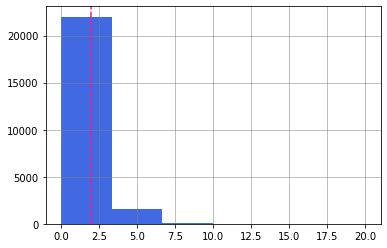

In [18]:
explorer.histogram(df.rooms, 6, 0, 20)

In [19]:
df.query('rooms == 0').count()

total_images            197
last_price              197
total_area              197
first_day_exposition    197
rooms                   197
ceiling_height           82
floors_total            194
living_area             183
floor                   197
is_apartment              6
studio                  197
open_plan               197
kitchen_area              0
balcony                 126
locality_name           197
airports_nearest        118
cityCenters_nearest     118
parks_around3000        118
parks_nearest            29
ponds_around3000        118
ponds_nearest            69
days_exposition         183
dtype: int64

197 наблюдений, что составляет менее 1 % от всей выборки (197 / 23699). Кандидаты на замену значений или удаление.

**- ceiling_height**

Данные о высоте потолков с ресурса potolki-info.ru: "В среднем, этот параметр колеблется в пределах **2,4–3,2 метра**. Минимальная высота потолка определяется СНиП как 2,5 м. Такие потолки характерны для хрущевок. В новостройках их минимальная высота составляет 2,6 метра. А в элитных домах она может быть более 3 м".

http://potolki-info.ru/kvartira/standartnaya-vysota-potolkov-normy-i-praktika

Сделаем выборку из датасета с данными о квартирах с высотой потолков менее 2.4 метра

In [20]:
df.ceiling_height.describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


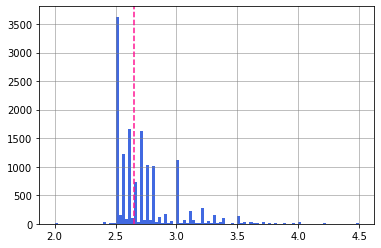

In [21]:
explorer.histogram(df.ceiling_height, 100, 2, 4.5)

In [22]:
df.query('ceiling_height < 2.4').count()

total_images            21
last_price              21
total_area              21
first_day_exposition    21
rooms                   21
ceiling_height          21
floors_total            21
living_area             18
floor                   21
is_apartment             4
studio                  21
open_plan               21
kitchen_area            18
balcony                 10
locality_name           21
airports_nearest         6
cityCenters_nearest      6
parks_around3000         6
parks_nearest            4
ponds_around3000         6
ponds_nearest            5
days_exposition         18
dtype: int64

Выведем срез на экран

In [23]:
df.query('ceiling_height < 2.4')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
227,13,2200000.0,47.00,2018-01-12T00:00:00,3,2.34,5.0,NaN,1,NaN,False,False,NaN,NaN,посёлок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,45.0
552,11,2999000.0,33.50,2017-03-30T00:00:00,1,2.00,15.0,17.500000,6,NaN,False,False,6.50,NaN,Санкт-Петербург,33972.0,11746.0,1.0,520.0,1.0,949.0,270.0
1582,4,4100000.0,45.60,2016-01-13T00:00:00,2,2.30,9.0,28.400000,8,False,False,False,7.00,2.0,Санкт-Петербург,49152.0,14977.0,1.0,489.0,1.0,525.0,329.0
2572,4,2400000.0,62.00,2018-12-27T00:00:00,3,2.00,5.0,40.000000,4,NaN,False,False,6.00,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.600000,9,NaN,False,False,8.80,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
5498,17,2200000.0,56.00,2018-04-02T00:00:00,2,2.30,5.0,45.000000,1,NaN,False,False,9.00,2.0,Сясьстрой,NaN,NaN,NaN,NaN,NaN,NaN,55.0
5712,5,1500000.0,42.80,2017-08-14T00:00:00,2,1.20,2.0,27.500000,1,NaN,False,False,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
5850,9,1650000.0,35.50,2018-05-29T00:00:00,1,2.00,5.0,NaN,5,NaN,False,False,NaN,NaN,Луга,NaN,NaN,NaN,NaN,NaN,NaN,100.0
11352,4,3300000.0,36.00,2017-06-18T00:00:00,1,2.00,17.0,15.200000,12,NaN,False,False,10.10,0.0,посёлок Металлострой,25268.0,26980.0,0.0,NaN,0.0,NaN,53.0
12755,2,1400000.0,22.50,2017-09-21T00:00:00,1,2.20,2.0,18.000000,2,NaN,False,False,4.50,1.0,село Копорье,NaN,NaN,NaN,NaN,NaN,NaN,45.0


21 наблюдение, что составляет менее 1 % от всей выборки (21 / 23699). Кандидаты на замену значений или удаление.

**- living_area**

Поскольку нельзя утверждать, что в датасете представлены исключительно квартиры, то необходимо учитывать, что в датасете содержаться объявления о продаже отдельных комнат, что может негативно влиять на общу. площадь. Из данных, полученных с помощью метода describe() минимальное значение жилой площади в датасете равно 2 квадратным метрам, что малоправдоподобно. Кроме того, на федеральном уровне определено, что минимальная санитарная норма жилой площади равна 6 квадратным метрам на одного человека. Проверим сколько значений жилой площади в датасете менее 6 квадратных метров.

In [24]:
df.living_area.describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

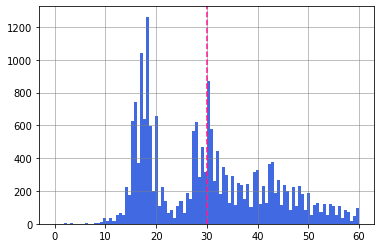

In [25]:
explorer.histogram(df.living_area, 100, 0, 60)

**Два пика - здесь что-то не то**

In [26]:
df.query('living_area <= 6').count()

total_images            7
last_price              7
total_area              7
first_day_exposition    7
rooms                   7
ceiling_height          4
floors_total            7
living_area             7
floor                   7
is_apartment            0
studio                  7
open_plan               7
kitchen_area            5
balcony                 2
locality_name           7
airports_nearest        6
cityCenters_nearest     6
parks_around3000        6
parks_nearest           4
ponds_around3000        6
ponds_nearest           3
days_exposition         7
dtype: int64

Выведем срез на экран

In [27]:
df.query('living_area <= 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,NaN,17.0,3.0,17,NaN,False,False,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.0,6.0,2.0,2,NaN,False,False,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
16431,13,3799000.0,31.0,2018-04-12T00:00:00,1,2.6,5.0,6.0,1,NaN,False,False,17.0,NaN,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0
17582,11,2680000.0,22.0,2018-08-11T00:00:00,0,NaN,25.0,5.0,8,NaN,True,False,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,NaN,24.0,2.0,22,NaN,True,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,4,2.5,9.0,5.4,1,NaN,False,False,9.8,NaN,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.0,8.0,3.0,8,NaN,False,False,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


Судя по содержанию соседних колонок - данные о жилой площади являются техническими ошибками: 7 наблюдений, что составляет менее 1 % от всей выборки (7 / 23699). Кандидаты на замену значений или удаление. 

**4) Исследуем колонку с ценой**

In [28]:
df.last_price.describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

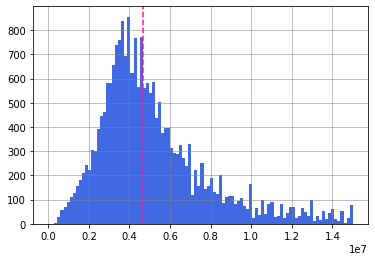

In [29]:
explorer.histogram(df.last_price, 100, 0, 15000000)

In [30]:
#df.last_price.hist(bins = 100, range = (0, 15000000))

### Вывод

1. В таблице содержится 23 699 наблюдений с множественными пропусками и бессмысленными значениями: самые существенные пропуски в столбцах с расстояниями от центра (5519), прудов (14 589) и парков (15 620), информации о высоте потолков (9 195), количестве балконов (11 519), и статусе недвижимости - is_apartment (20 924).
2. Пропуски в столбцах с расстояниями до различных объектов очень критичны, поскольку получены автоматически и исходя из количества пропусков будет трудно восстановить их на основе других столбцов. Пропуски в этих столбцах могут свидетельствовать о системной ошибке при сборе данных.
3. В распределении значений жилой площади неожиданно два пика. Посмотрим, что будет после очистки данных.
4. Наиболее сильная корреляция с показателями цены наблюдется с данным о площади, жилой площади, площади кухни, количестве комнат; корреляция по данным показателям положительная.

### 2. Предобработка данных

**1) Исправим регистр в наименовании колонок с помощью строкового метода str.lower().**

In [31]:
df.columns = df.columns.str.lower()

Проверим результат

In [32]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'citycenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

**2)  Заполним пропуски в столбце is_apartment и balcony**

**- is_apartment**

С учетом ранее полученных данных о пропусках в колонке is_apartment, принимая во внимание, что апартамент в принципе встречаются значительно реже - будем исходить из того, что NaN - индикатор нежилого статуса недвижимости. **Заполним NaN значением False - 20 924 наблюдений из 23 699.**

In [33]:
df.is_apartment.fillna(False, inplace = True)

Проверим результат

In [34]:
df.is_apartment.isna().any()

False

**- balcony**

Проверим количество пропусков в данных о балконах

In [35]:
df.balcony.isna().value_counts()

False    12180
True     11519
Name: balcony, dtype: int64

Почти половина ячеек содержит NaN. Скорее всего, это означает, что продавец умолчал информацию о количестве балконов, потому что их нет. Корреляция между количеством балконов и ценой - слабая (0,023). Таким образом, **заполним NaN плейсхолдером - 0 (11 519 значений из 23 699).**

In [36]:
df.balcony.fillna(0, inplace = True)

In [37]:
df.balcony.isna().any()

False

**3)  Заполним пропуски и заменим странные значения в столбце ceiling_height**

Вычислим моду для значения высоты потоков в датасете с помощью метода mode()

In [38]:
df.ceiling_height.mode()

0    2.5
dtype: float64

Ожидаемые 2,5 метра. Заменим 9 195 пропусков и значения менее 2,5 метров (всего 21 наблюдение) на стандартные -  2.5 метра.

In [39]:
df.loc[(df.ceiling_height < 2.5), 'ceiling_height'] = 2.5

In [40]:
df.ceiling_height.isna().value_counts()

False    14504
True      9195
Name: ceiling_height, dtype: int64

In [41]:
df.ceiling_height.fillna(2.5, inplace = True)

Проверим результат

In [42]:
df.ceiling_height.isna().any()

False

**4)  Заполним пропуски в столбце floors_total**

В столбце всего 86 строк с пропущенными данными об общей этажности дома: вычислим моду с помощью метода mode(), напишем функцию, которая заменит нужные значения, применим функцию с помощью метода apply()

In [43]:
df.floors_total.mode()

0    5.0
dtype: float64

В выборке самое частое значение - 5 этажей.

Напишем и применим функцию, которая будет заменять пропуски на 5 этажей, если квартира расположена ниже 5 этажа, а в остальных случаях заполнять пустую ячейку значением из ячейки с данными о этаже на котором расположена квартира

In [44]:
def floors_total_fixer(row):
    total_floor = row['floors_total']
    floor = row['floor']
    
    if math.isnan(total_floor) and floor <= 5:
        return 5
    elif math.isnan(total_floor) and floor > 5:
        return floor
    else:
        return total_floor

In [45]:
df['floors_total'] = df.apply(floors_total_fixer, axis=1)

Проверим результат

In [46]:
df.floors_total.isna().any()

False

**5) Заполним пропуски в столбце living_area**

Вычислим отношение жилой площади к жилой, создадим для этого колонку, и с помощью метода describe() получим данные о медиане и среднем значении

In [47]:
df['living_area_percentage'] = df.living_area / df.total_area

In [48]:
df.living_area_percentage.describe()

count    21796.000000
mean         0.564766
std          0.105368
min          0.021583
25%          0.495177
50%          0.567860
75%          0.637880
max          1.000000
Name: living_area_percentage, dtype: float64

Медина и среднее в данном случае близки - примерно 56 % от общей площади являтеся жилой. Используем это, чтобы заполнить пропуски - 1 903‬ наблюдение.

In [49]:
df.living_area.fillna(df.total_area * 0.56, inplace = True)

Проверим результат

In [50]:
df.living_area.isna().any()

False

Заполним столбец с учетом восполненных данных и выведем методом describe() информацию о нем

In [51]:
df['living_area_percentage'] = df.living_area / df.total_area

In [52]:
df.living_area_percentage.describe()

count    23699.000000
mean         0.564383
std          0.101057
min          0.021583
25%          0.500000
50%          0.560000
75%          0.631579
max          1.000000
Name: living_area_percentage, dtype: float64

После замены разброс значений существенно не поменялся

**6) Решим судьбу пропусков в столбце kitchen_area**

В датасете 2 278‬ пропусков с площадью кухни.

- Возможно это студии:

In [53]:
df.studio.value_counts()

False    23550
True       149
Name: studio, dtype: int64

Всего 149 студий

In [54]:
df.groupby(by = 'studio').kitchen_area.count()

studio
False    21421
True         0
Name: kitchen_area, dtype: int64

**Во всех случаях, когда продается студия - площадь кухни не указана.**

- Проверим пересечения студий и пропущенных значения

In [55]:
df.query('kitchen_area.isna() and studio == True').pivot_table(values = 'last_price', index = 'studio', aggfunc = 'count')

,last_price
studio,
True,149


**Всего 149 значений из 2 278 пропущенных. Заменим 149 пропусков в объявлениях о студии на плейсхолдер - "0" с помощью метода .where().**

In [56]:
df.kitchen_area.where(df.studio != True, 0, inplace = True)

Проверим результат

In [57]:
df.query('kitchen_area.isna() and studio == True').kitchen_area.value_counts()

Series([], Name: kitchen_area, dtype: int64)

- Выведем срез с пропущенными значениями в kitchen_area

In [58]:
df.query('kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_percentage
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.50,14.0,89.040,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0.560000
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.50,9.0,18.368,2,False,False,False,NaN,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0,0.560000
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,25.648,1,False,False,False,NaN,0.0,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0,0.560000
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.50,22.0,22.400,3,False,False,False,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN,0.560000
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.50,13.0,26.040,13,False,False,False,NaN,0.0,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0,0.560000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23655,1,2414306.0,40.5,2016-09-08T00:00:00,1,2.56,18.0,19.600,10,False,False,False,NaN,0.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,627.0,0.483951
23663,12,6400000.0,88.0,2018-01-12T00:00:00,4,2.55,10.0,49.280,1,False,False,False,NaN,0.0,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0,0.560000
23670,9,2450000.0,45.6,2018-02-08T00:00:00,1,2.80,9.0,25.536,2,False,False,False,NaN,0.0,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.560000
23679,0,2500000.0,35.0,2017-12-08T00:00:00,1,2.50,9.0,19.600,4,False,False,False,NaN,0.0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.560000


Рассмотрим три варианта:
- **заполнение будет происходить путем простой арифметической операции** - отнимем от общей площади жилую. Это уместное допущение, поскольку результат будет близким к реальному, а получить пояснения у ответсенного за сбор данных не представляется возможным.
- **заполнение будет происходить арифметической операцией с процентным соотношением по среднему** - по аналогии с жилой площадью вычислим процент от общей площади и заполним пропуски.
- **избавимся от этих пропусков путем удаления**, потому что: 1) нельзя утверждать, что в выборке представлены только квартиры - может быть, продают комнату; 2) продавец просто не указал значение; 3) уточнить данные не представляется возможным.

Вариант с заполнением ячеек разницей между общей площадью и жилой площадью - все же искажает результат. Удалить 2 278 наблюдений из 23 699 - означает избавиться от почти 10 % всех налюдений вообще. **Поэтому будет применено заполнение путем вычисления процентного соотношения к общей площади.**

Выведем данные по столбцу kitchen_area с помощью метода describe(), чтобы после замены проверить отсутствие существенных искажений

In [59]:
df.kitchen_area.describe()

count    21570.000000
mean        10.496794
std          5.949767
min          0.000000
25%          7.000000
50%          9.010000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Создадим технический столбец kitchen_area_percentage с соотношением площади кухни к общей площади

In [60]:
df['kitchen_area_percentage'] = df.kitchen_area / df.total_area

Выведем данные по столбцу kitchen_area_percentage с помощью метода describe()

In [61]:
df.kitchen_area_percentage.describe()

count    21570.000000
mean         0.186061
std          0.074353
min          0.000000
25%          0.133003
50%          0.171867
75%          0.231245
max          0.787879
Name: kitchen_area_percentage, dtype: float64

Медина составляет 17 % от общей площади являтеся жилой. Используем это, чтобы заполнить пропуски

In [62]:
df.kitchen_area.fillna((df.total_area * 0.17), inplace = True)

Убедимся, что замена не исказила данные

In [63]:
df.kitchen_area.describe()

count    23699.000000
mean        10.448609
std          6.058299
min          0.000000
25%          7.000000
50%          9.000000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Проверим общий результат

In [64]:
df.kitchen_area.isna().any()

False

Заполним столбец с учетом восполненных данных и выведем методом describe() информацию о нем

In [65]:
df['kitchen_area_percentage'] = df.kitchen_area / df.total_area

In [66]:
df.kitchen_area_percentage.describe()

count    23699.000000
mean         0.184618
std          0.071083
min          0.000000
25%          0.136261
50%          0.170000
75%          0.223717
max          0.787879
Name: kitchen_area_percentage, dtype: float64

**7) Решим, что делать со значением равным "0" в столбце rooms**

Ранее было выявлено 197 наблюдений со значением комнат равным "0". Проверим - пересекаются ли эти наблюдения со студиями.

In [67]:
df.query('rooms == 0 and studio == True').studio.value_counts()

True    138
Name: studio, dtype: int64

**138 студий и 138 случаев с "0" комнат - в этом случае ничего менять не будем. Но остается еще 59 строк. Выведем их все**

In [68]:
df.query('rooms == 0 and studio == False')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_percentage,kitchen_area_percentage
349,4,2320000.0,25.00,2017-09-27T00:00:00,0,2.50,14.0,17.000,1,False,False,True,4.2500,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.680000,0.17
508,0,3375000.0,34.40,2017-03-28T00:00:00,0,2.50,26.0,24.300,19,False,False,True,5.8480,1.0,посёлок Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0,0.706395,0.17
780,9,2600000.0,26.10,2018-02-20T00:00:00,0,2.50,18.0,14.616,8,False,False,True,4.4370,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,45.0,0.560000,0.17
839,14,1900000.0,35.00,2017-04-14T00:00:00,0,2.70,5.0,15.000,3,False,False,True,5.9500,1.0,поселок Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.428571,0.17
946,5,2200000.0,23.00,2016-09-27T00:00:00,0,2.50,27.0,18.000,7,False,False,True,3.9100,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,483.0,0.782609,0.17
1574,0,2200000.0,22.00,2017-11-03T00:00:00,0,2.50,18.0,15.000,16,False,False,True,3.7400,1.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,81.0,0.681818,0.17
1625,7,1980000.0,23.98,2018-02-01T00:00:00,0,2.50,4.0,10.500,3,False,False,True,4.0766,1.0,поселок станции Корнево,NaN,NaN,NaN,NaN,NaN,NaN,120.0,0.437865,0.17
2532,5,3500000.0,27.10,2018-02-01T00:00:00,0,2.50,18.0,18.700,9,False,False,True,4.6070,2.0,Санкт-Петербург,32036.0,8175.0,0.0,NaN,1.0,644.0,70.0,0.690037,0.17
3019,18,2100000.0,24.00,2017-11-10T00:00:00,0,2.50,10.0,18.000,6,False,False,True,4.0800,2.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.750000,0.17
4115,7,2600000.0,24.00,2018-02-01T00:00:00,0,2.50,25.0,18.000,4,False,False,True,4.0800,2.0,Санкт-Петербург,10031.0,13330.0,1.0,915.0,0.0,NaN,42.0,0.750000,0.17


**Судя по параметрам - это могут быть однокомнатные квартиры. Выведем описание среза с помощью метода describe() и сравним с описанием среза с однокомнытными квартирами**

In [69]:
df.query('rooms == 0 and studio == False').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_percentage,kitchen_area_percentage
count,59.000000,5.900000e+01,59.000000,59.0,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,31.000000,31.000000,31.000000,9.000000,31.000000,21.000000,59.000000,59.000000,5.900000e+01
mean,7.423729,3.911034e+06,32.707288,0.0,2.968136,17.559322,21.590915,9.610169,5.560239,1.237288,25054.354839,13577.870968,0.387097,665.111111,0.935484,517.619048,77.474576,0.686929,1.700000e-01
std,5.531114,8.910509e+06,44.986261,0.0,3.186738,6.891452,24.896302,6.843111,7.647664,0.857804,13276.323677,5014.710166,0.667204,242.505899,0.892020,283.847754,103.924103,0.117898,2.823006e-17
min,0.000000,1.315000e+06,16.000000,0.0,2.500000,4.000000,10.500000,1.000000,2.720000,0.000000,10031.000000,2111.000000,0.000000,228.000000,0.000000,72.000000,3.000000,0.428571,1.700000e-01
25%,3.500000,2.310000e+06,25.000000,0.0,2.500000,12.000000,16.450000,4.000000,4.250000,0.000000,15606.000000,11904.500000,0.000000,518.000000,0.000000,232.000000,18.500000,0.632456,1.700000e-01
50%,7.000000,2.600000e+06,26.100000,0.0,2.500000,18.000000,18.000000,8.000000,4.437000,2.000000,20735.000000,13222.000000,0.000000,733.000000,1.000000,584.000000,45.000000,0.680000,1.700000e-01
75%,10.000000,3.277500e+06,28.250000,0.0,2.500000,24.000000,20.000000,13.500000,4.802500,2.000000,32726.000000,16814.000000,1.000000,761.000000,1.000000,767.000000,81.500000,0.730330,1.700000e-01
max,21.000000,7.100000e+07,371.000000,0.0,27.000000,35.000000,207.760000,26.000000,63.070000,2.000000,53791.000000,23810.000000,2.000000,1021.000000,3.000000,936.000000,483.000000,1.000000,1.700000e-01


In [70]:
df.query('rooms == 1 and studio == False').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_percentage,kitchen_area_percentage
count,8036.000000,8.036000e+03,8036.000000,8036.0,8036.000000,8036.000000,8036.000000,8036.000000,8036.000000,8036.000000,5878.000000,5883.000000,5883.000000,2277.000000,5883.000000,2845.000000,7262.000000,8036.000000,8036.000000
mean,9.140244,3.836791e+06,37.658703,1.0,2.624602,12.622325,18.239179,6.930687,9.203741,0.575037,29760.291426,15660.106238,0.507394,506.995608,0.696413,532.723726,159.037318,0.491780,0.241722
std,5.323638,1.900621e+06,9.335901,0.0,1.247367,7.008616,4.868110,5.451379,3.457033,0.836604,13430.970908,7988.929938,0.734170,366.568776,0.866251,280.612804,198.725102,0.086383,0.060529
min,0.000000,4.300000e+05,12.000000,1.0,2.500000,1.000000,3.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,4.000000,0.000000,19.000000,2.000000,0.073171,0.045614
25%,5.000000,2.902744e+06,32.500000,1.0,2.500000,6.000000,16.100000,3.000000,6.800000,0.000000,17915.750000,11486.500000,0.000000,287.000000,0.000000,315.000000,39.000000,0.434916,0.194646
50%,9.000000,3.600000e+06,36.600000,1.0,2.500000,11.000000,17.800000,5.000000,9.000000,0.000000,29293.000000,14265.000000,0.000000,455.000000,0.000000,511.000000,81.000000,0.491653,0.238710
75%,13.000000,4.450000e+06,41.000000,1.0,2.670000,17.000000,19.200000,10.000000,10.800000,1.000000,39620.750000,17172.000000,1.000000,629.000000,1.000000,749.000000,200.000000,0.553072,0.272727
max,30.000000,4.351100e+07,494.100000,1.0,100.000000,52.000000,276.696000,31.000000,83.997000,5.000000,78527.000000,60223.000000,3.000000,3190.000000,3.000000,1344.000000,1512.000000,0.975754,0.787879


Значение близки, но не идентичны. Проверим на сходство со студиями.

In [71]:
df.query('rooms == 0 and studio == True').describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_percentage,kitchen_area_percentage
count,138.000000,1.380000e+02,138.000000,138.0,138.000000,138.000000,138.000000,138.000000,138.0,138.000000,87.000000,87.000000,87.000000,20.000000,87.000000,48.000000,124.000000,138.000000,138.0
mean,7.927536,3.092613e+06,27.814348,0.0,2.658913,16.492754,18.665188,8.137681,0.0,0.913043,24324.758621,13321.172414,0.264368,563.250000,0.781609,529.729167,124.266129,0.672113,0.0
std,4.886504,1.616292e+06,9.611879,0.0,0.325880,6.936886,7.339263,6.011172,0.0,0.939625,12129.218067,5060.667667,0.516242,327.086642,0.868376,273.741588,177.571014,0.113840,0.0
min,0.000000,9.457500e+05,15.500000,0.0,2.500000,3.000000,2.000000,1.000000,0.0,0.000000,6989.000000,1261.000000,0.000000,38.000000,0.000000,80.000000,3.000000,0.086957,0.0
25%,4.000000,2.300000e+06,24.000000,0.0,2.500000,12.000000,16.000000,3.000000,0.0,0.000000,13985.000000,10929.000000,0.000000,361.000000,0.000000,362.250000,28.000000,0.597761,0.0
50%,7.000000,2.810000e+06,26.000000,0.0,2.575000,17.000000,17.950000,7.000000,0.0,1.000000,21460.000000,14069.000000,0.000000,527.500000,1.000000,508.000000,58.500000,0.687349,0.0
75%,11.000000,3.437500e+06,28.775000,0.0,2.747500,23.000000,19.157500,12.750000,0.0,2.000000,34201.000000,16216.000000,0.000000,775.750000,1.000000,665.750000,159.250000,0.727915,0.0
max,20.000000,1.630000e+07,98.400000,0.0,5.800000,35.000000,68.000000,24.000000,0.0,2.000000,55551.000000,29846.000000,2.000000,1199.000000,3.000000,1159.000000,931.000000,0.957746,0.0


Значения заметно ближе. **Заполним нули исходя из того, что это студии.**

In [72]:
df.loc[(df.rooms == 0) & (df.studio == False), 'studio'] = True

Проверим результат

In [73]:
df.query('rooms == 0 and studio == True').studio.count()

197

**8) Примем решение в отношение пропусков в столбцах с характеристиками расстояний до различных объектов**

- Посчитаем строки с пропущенными значениями близжайшего аэропорта и названием населенного пункта "Санкт-Петербург".

In [74]:
df.query('locality_name == "Санкт-Петербург" and airports_nearest.isna()').airports_nearest.isna().value_counts()

True    85
Name: airports_nearest, dtype: int64

Всего 85 значений.

- Посчитаем строки с пропущенными значениями близжайшего аэропорта и названием населенного пункта отличного от "Санкт-Петербург".

In [75]:
df.query('locality_name != "Санкт-Петербург" and airports_nearest.isna()').airports_nearest.isna().value_counts()

True    5457
Name: airports_nearest, dtype: int64

5457 строк.

Выведем срез на экран

In [76]:
pd.DataFrame(df.query('locality_name != "Санкт-Петербург" and airports_nearest.isna()').locality_name.value_counts().sort_values(ascending = False))

,locality_name
посёлок Мурино,522
Всеволожск,398
Гатчина,307
деревня Кудрово,299
Выборг,237
...,...
посёлок городского типа Рябово,1
поселок Пчевжа,1
коттеджный посёлок Лесное,1
посёлок Мыза-Ивановка,1


В столбцах airports_nearest, citycenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - пропуски.  Для Ленинградской области систематически не собираются данные о расстоянии до различных объектов. Сохраним срез в переменную df_len_obl.

In [77]:
df_len_obl = df.query('locality_name != "Санкт-Петербург" and airports_nearest.isna()')

В описании данных указано, что по каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, а вторые — получены **автоматически** на основе картографических данных. Например, **расстояние до центра, аэропорта, ближайшего парка и водоёма.**

**Поскольку данные о расстоянии собираются автоматически, а пропусков много - представляется, что в процессе сбора даных есть системная ошибка из-за которой данные не заполняются.**

- Проверим можно ли заполнить значения в пропусках расстояний для Санкт-Петербурга по соседствующим с ними объектам. 

In [78]:
df.query('locality_name == "Санкт-Петербург" and airports_nearest.isna()').citycenters_nearest.unique()

array([   nan, 13355.,  9734.,  5735.,  4892., 21377., 11835., 11246.])

In [79]:
ccnspb = [13355.,  9734.,  5735.,  4892., 21377., 11835., 11246.]

In [80]:
df.query('locality_name == "Санкт-Петербург" and citycenters_nearest == @ccnspb').sample(11)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_percentage,kitchen_area_percentage
11446,5,4000000.0,45.0,2016-09-07T00:00:00,2,2.55,5.0,28.2,3,False,False,False,6.0,0.0,Санкт-Петербург,NaN,11835.0,1.0,267.0,1.0,601.0,224.0,0.626667,0.133333
7521,16,43500000.0,245.8,2015-12-17T00:00:00,3,4.45,7.0,170.8,7,True,False,False,25.0,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1067.0,0.694874,0.101709
12401,20,91500000.0,495.0,2017-06-19T00:00:00,7,4.65,7.0,347.5,7,False,False,False,25.0,0.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,14.0,0.702020,0.050505
16470,7,11900000.0,101.0,2017-04-15T00:00:00,3,2.75,19.0,56.0,9,False,False,False,15.0,0.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,21.0,0.554455,0.148515
19430,9,3900000.0,30.5,2018-02-22T00:00:00,1,2.60,5.0,16.5,1,False,False,False,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,176.0,0.540984,0.180328
18222,20,9500000.0,70.2,2017-04-15T00:00:00,2,2.80,23.0,40.0,10,False,False,False,12.0,0.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,118.0,0.569801,0.170940
21075,1,3650000.0,48.8,2017-06-24T00:00:00,4,2.50,5.0,37.0,1,False,False,False,5.2,0.0,Санкт-Петербург,NaN,11246.0,0.0,NaN,0.0,NaN,174.0,0.758197,0.106557
22790,8,5600000.0,47.0,2017-09-27T00:00:00,1,2.50,23.0,21.0,7,False,False,False,11.0,1.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,10.0,0.446809,0.234043
9054,5,13000000.0,71.8,2017-09-12T00:00:00,2,2.75,10.0,32.5,5,False,False,False,18.9,2.0,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,156.0,0.452646,0.263231
8018,20,84000000.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,True,False,False,45.5,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0,0.594675,0.089744


Выведем срез без пропусков в столбцах airports_nearest и citycenters_nearest

In [81]:
df.query('locality_name == "Санкт-Петербург" and citycenters_nearest == @ccnspb and airports_nearest.isna() == False')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,living_area_percentage,kitchen_area_percentage
3916,20,26500000.0,160.0,2019-02-11T00:00:00,5,2.5,5.0,100.0,4,False,False,False,36.0,0.0,Санкт-Петербург,14559.0,13355.0,2.0,186.0,2.0,347.0,NaN,0.625000,0.225000
4687,4,5580000.0,59.0,2018-10-11T00:00:00,4,2.5,5.0,43.0,4,False,False,False,6.9,0.0,Санкт-Петербург,9823.0,11246.0,0.0,NaN,0.0,NaN,NaN,0.728814,0.116949
10959,9,3000000.0,31.1,2017-03-21T00:00:00,1,2.5,5.0,17.7,2,False,False,False,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,234.0,0.569132,0.176849
13307,7,5400000.0,54.4,2018-01-17T00:00:00,2,2.5,10.0,30.0,8,False,False,False,8.4,4.0,Санкт-Петербург,29080.0,11246.0,1.0,546.0,1.0,593.0,21.0,0.551471,0.154412
19430,9,3900000.0,30.5,2018-02-22T00:00:00,1,2.6,5.0,16.5,1,False,False,False,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,176.0,0.540984,0.180328


**К сожалению, заполнить пропуски простой подстановкой значения по соседствующим объектам не представляется возможным: значения в parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - носят неидентифицирующий характер. Расстояния до аэропорта может совпадать, но, например, различие по расстоянию до парка, а равно как и количество прудов и парков в районе трех киллометров может свидетельстовать о том, что речь о разных районах. Как следстие это может означать и иное расстояние до аэропорта**.

В столбце parks_nearest - 8079 пропусков, в столбце ponds_nearest 9110 пропусков - опираться на эти столбы для заполненяи соседних затруднительно.

В отсутствии возможности запросить ответсвенного за сбор данных **принято решение отбросить столбцы parks_nearest, ponds_nearest**: во-первых, данные показатели зависят от города в котором расположена квартира, это не универсальный показатель во-вторых эффективного способа восстановить данные показатели без получения фактических данных не усматривается.

**- Сделаем копию датафрейма и избавимся от столбцов parks_nearest, ponds_nearest**

In [82]:
df_including_distance = df.copy()

In [83]:
df = df.drop(['parks_nearest', 'ponds_nearest'], 1)

Выведем первые пять столбцов полученной таблицы

In [84]:
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,ponds_around3000,days_exposition,living_area_percentage,kitchen_area_percentage
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0,NaN,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.50,11.0,18.60,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,0.0,81.0,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.50,5.0,34.30,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,2.0,558.0,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.50,14.0,89.04,9,False,False,False,27.03,0.0,Санкт-Петербург,28098.0,6800.0,2.0,3.0,424.0,0.560000,0.170000
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,1.0,121.0,0.320000,0.410000


**Заполним пропуски в значениях рассояний до аэропорта, городского центра, парков и прудов**

- значения расстония до центра и аэропорта полезны для Петербурга, но как универсальный атрибут растояние до центра и аэропорта в данной выборке не работает,
- поскольку отсутсвует возможность запросить корректные данные, в отношении других пропусков нужен плейсхолдер, который будет означать отстутствие данных,
- возьмем за плейсхолдер - 0, искажения не должно быть, поскольку возможно будет сделать срез данных только по Петербургу,
- этот же плейсхолдер будет использован для заполнения отсутсвующих значений в столбцах parks_around3000, ponds_around3000 - будет означать, что в районе трех километров прудов и парков нет.

In [85]:
df.airports_nearest.fillna(0, inplace = True)
df.citycenters_nearest.fillna(0, inplace = True)
df.parks_around3000.fillna(0, inplace = True)
df.ponds_around3000.fillna(0, inplace = True)

**9) Проверим пропуски в столбце locality_name**

In [86]:
df.query('locality_name.isna()').locality_name.isna().value_counts()

True    49
Name: locality_name, dtype: int64

Сорок девять пропусков. Выведем таблицу, чтобы решить как с ними поступить.

In [87]:
df.query('locality_name.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,ponds_around3000,days_exposition,living_area_percentage,kitchen_area_percentage
1097,3,8600000.0,81.70,2016-04-15T00:00:00,3,3.55,5.0,50.800,2,False,False,False,8.800,0.0,NaN,23478.0,4258.0,0.0,0.0,147.0,0.621787,0.107711
2033,6,5398000.0,80.00,2017-05-30T00:00:00,3,2.50,4.0,42.600,2,False,False,False,18.600,0.0,NaN,0.0,0.0,0.0,0.0,34.0,0.532500,0.232500
2603,20,3351765.0,42.70,2015-09-20T00:00:00,1,2.50,24.0,15.600,3,False,False,False,10.700,0.0,NaN,22041.0,17369.0,0.0,1.0,276.0,0.365340,0.250585
2632,2,5130593.0,62.40,2015-10-11T00:00:00,2,2.50,24.0,33.100,21,False,False,False,8.200,0.0,NaN,22041.0,17369.0,0.0,1.0,256.0,0.530449,0.131410
3574,10,4200000.0,46.50,2016-05-28T00:00:00,2,2.50,5.0,30.800,5,False,False,False,6.500,0.0,NaN,27419.0,8127.0,0.0,1.0,45.0,0.662366,0.139785
4151,17,17600000.0,89.50,2014-12-09T00:00:00,2,3.00,8.0,39.620,7,False,False,False,13.380,0.0,NaN,25054.0,3902.0,1.0,3.0,869.0,0.442682,0.149497
4189,7,9200000.0,80.00,2015-12-10T00:00:00,3,4.00,4.0,52.300,3,False,False,False,10.400,0.0,NaN,21774.0,3039.0,1.0,1.0,223.0,0.653750,0.130000
4670,1,5500000.0,83.00,2015-08-14T00:00:00,3,2.50,7.0,46.480,6,False,False,False,14.110,0.0,NaN,26534.0,5382.0,1.0,1.0,350.0,0.560000,0.170000
5343,19,13540000.0,85.50,2016-01-20T00:00:00,3,2.50,7.0,59.100,5,False,False,False,8.300,4.0,NaN,10556.0,9538.0,1.0,0.0,303.0,0.691228,0.097076
5707,7,3700000.0,30.00,2016-04-29T00:00:00,1,2.50,24.0,20.000,23,False,False,False,5.100,0.0,NaN,21460.0,16788.0,0.0,1.0,49.0,0.666667,0.170000


Визульно видно, что значения в столбцах airports_nearest и citycenters_nearest попарно повторяются. Соберем из значений этих столбцов два списка и попробуем проверить соответствуют ли эти значения Санкт-Петербургу, который повторяется в датасете чаще других.

In [88]:
df.query('locality_name.isna()').airports_nearest.unique()

array([23478.,     0., 22041., 27419., 25054., 21774., 26534., 10556.,
       21460., 14031., 25925., 37123., 24233., 19659., 24953., 25771.,
       25221., 25680., 20234., 35920., 36380., 21731., 21219., 36865.,
       11206., 21540., 21654., 24385., 19744., 60195., 26090., 23297.])

In [89]:
df.query('locality_name.isna()').citycenters_nearest.unique()

array([ 4258.,     0., 17369.,  8127.,  3902.,  3039.,  5382.,  9538.,
       16788.,  8582.,  4627., 12332.,  4065., 31813.,  3801.,  4474.,
        4069.,  4383., 23659.,  9633.,  9497.,  8619.,  1322., 10976.,
        8943.,  8429.,  3312.,  4604., 31897., 41294.,  4805.,  1780.])

In [90]:
(df.query('locality_name.isna()').airports_nearest.astype(str)+'_'+df.query('locality_name.isna()').citycenters_nearest.astype(str)).unique()

array(['23478.0_4258.0', '0.0_0.0', '22041.0_17369.0', '27419.0_8127.0',
       '25054.0_3902.0', '21774.0_3039.0', '26534.0_5382.0',
       '10556.0_9538.0', '21460.0_16788.0', '14031.0_8582.0',
       '25925.0_4627.0', '37123.0_12332.0', '24233.0_4065.0',
       '19659.0_31813.0', '24953.0_3801.0', '25771.0_4474.0',
       '25221.0_4069.0', '25680.0_4383.0', '20234.0_23659.0',
       '35920.0_9633.0', '36380.0_9497.0', '21731.0_8619.0',
       '21219.0_1322.0', '36865.0_10976.0', '11206.0_8943.0',
       '21540.0_8429.0', '21654.0_3312.0', '24385.0_4604.0',
       '19744.0_31897.0', '60195.0_41294.0', '26090.0_4805.0',
       '23297.0_1780.0'], dtype=object)

В ручную исключим несколько пропусков и создадим два списка.

In [91]:
list1 = [23478., 22041., 27419., 25054., 21774., 26534., 10556., 21460., 14031., 25925., 37123., 24233., 19659., 24953., 25771., 25221., 25680., 20234., 35920., 36380., 21731., 21219., 36865., 11206., 21540., 21654., 24385., 19744., 60195., 26090., 23297.]
list2 = [4258., 17369., 8127., 3902., 3039., 5382., 9538., 16788., 8582., 4627., 12332., 4065., 31813., 3801., 4474., 4069., 4383., 23659., 9633., 9497., 8619., 1322., 10976., 8943., 8429., 3312., 4604., 31897., 41294., 4805., 1780.]

Убедимся, что оба списка равны по длине.

In [92]:
len(list1) == len(list2)

True

Подсчитаем число строк с пропущенными названиями населенного пункта, характеристики которого соответствуют Санкт-Петербургу

In [93]:
df.query('airports_nearest == @list1 and citycenters_nearest == @list2 and locality_name.isna()').locality_name.isna().value_counts()

True    41
Name: locality_name, dtype: int64

41 строка. Заменим пустые значения на Санкт-Петербург.

In [94]:
df.loc[(df['airports_nearest'].isin(list1)) & (df.citycenters_nearest.isin(list2)) & (df.locality_name.isna()), 'locality_name']= \
'Санкт-Петербург'

Выведем оставшиеся строки с пропущенным названием населенного пункта, чтобы проверить можно ли с ними что-то сделать.

In [95]:
df.query('locality_name.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,ponds_around3000,days_exposition,living_area_percentage,kitchen_area_percentage
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,2.5,4.0,42.600,2,False,False,False,18.600,0.0,NaN,0.0,0.0,0.0,0.0,34.0,0.532500,0.232500
14342,3,3611000.0,53.5,2017-04-27T00:00:00,1,2.5,4.0,25.800,3,False,False,False,9.095,1.0,NaN,0.0,0.0,0.0,0.0,92.0,0.482243,0.170000
17535,2,5985000.0,79.8,2018-07-30T00:00:00,3,2.5,9.0,44.688,2,False,False,False,13.566,0.0,NaN,0.0,0.0,0.0,0.0,213.0,0.560000,0.170000
20382,8,1750000.0,72.9,2018-10-27T00:00:00,3,2.5,5.0,47.300,2,False,False,False,8.300,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.648834,0.113855
20590,7,3380000.0,56.0,2017-11-06T00:00:00,2,2.7,4.0,29.000,3,False,False,False,10.000,1.0,NaN,0.0,0.0,0.0,0.0,78.0,0.517857,0.178571
21715,2,6047550.0,80.1,2018-07-30T00:00:00,2,2.5,9.0,30.500,2,False,False,False,29.200,0.0,NaN,0.0,0.0,0.0,0.0,176.0,0.380774,0.364544
21898,2,5886750.0,83.5,2018-07-30T00:00:00,2,2.5,9.0,36.600,2,False,False,False,29.700,0.0,NaN,0.0,0.0,0.0,0.0,169.0,0.438323,0.355689
22717,9,3000000.0,35.0,2018-01-02T00:00:00,1,2.6,16.0,16.000,7,False,False,False,10.000,1.0,NaN,0.0,0.0,0.0,0.0,75.0,0.457143,0.285714


К сожалению, содержание строк не позволяют установить о каком населенном пункте идет речь. Удалим эти строки - всего 8 пропусков. 

In [96]:
df.dropna(subset=['locality_name'], inplace=True)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23691 entries, 0 to 23698
Data columns (total 22 columns):
total_images               23691 non-null int64
last_price                 23691 non-null float64
total_area                 23691 non-null float64
first_day_exposition       23691 non-null object
rooms                      23691 non-null int64
ceiling_height             23691 non-null float64
floors_total               23691 non-null float64
living_area                23691 non-null float64
floor                      23691 non-null int64
is_apartment               23691 non-null bool
studio                     23691 non-null bool
open_plan                  23691 non-null bool
kitchen_area               23691 non-null float64
balcony                    23691 non-null float64
locality_name              23691 non-null object
airports_nearest           23691 non-null float64
citycenters_nearest        23691 non-null float64
parks_around3000           23691 non-null float64
ponds_ar

- В таблице обращает внимание Мурино и Кудрово, которые в таблице предствлено тремя различными вариантами написания. Проверим на примере Мурино и Кудрово и примем решение в отношении данного столбца.

In [98]:
kudrovo_murino = ['Мурино', 'Кудрово', 'поселок Мурино', 'посёлок Мурино', 'деревня Кудрово']

In [99]:
df.query('locality_name in @kudrovo_murino').pivot_table(values = 'last_price', index = 'locality_name', aggfunc = 'count')

,last_price
locality_name,
Кудрово,173
Мурино,34
деревня Кудрово,299
поселок Мурино,34
посёлок Мурино,522


Два населенных пункта искуственно разделены. Возможно, есть и другие задвоения, связанные с особенностями написания.

In [100]:
df.locality_name.nunique()

364

В столбце 364 уникальных имени.

In [101]:
df.pivot_table(values = 'last_price', index = 'locality_name', aggfunc = 'count').sort_values(by = 'last_price', ascending = False).head(10)

,last_price
locality_name,
Санкт-Петербург,15762
посёлок Мурино,522
посёлок Шушары,440
Всеволожск,398
Пушкин,369
Колпино,338
посёлок Парголово,327
Гатчина,307
деревня Кудрово,299


В данном случае, существенной информации тип населенного не несет, но может быть источником задвоений в датасете. Поэтому с помощью lambda-функции выделим из столбца только названия, отбросив тип населенного пункта.<font>

In [102]:
df['locality_name'] = df['locality_name'].apply(lambda name: ' '.join(filter(str.istitle, name.split())))

Проверим результат<font>

In [103]:
df.locality_name.nunique()

305

Осталось 305 из 364 уникальных значений. Кудрово и Мурино были только самыми заметными задвоениями<font>

Проверим результат

In [104]:
df.pivot_table(values = 'last_price', index = 'locality_name', aggfunc = 'count').sort_values(by = 'last_price', ascending = False).head(10)

,last_price
locality_name,
Санкт-Петербург,15762
Мурино,590
Кудрово,472
Шушары,440
Всеволожск,398
Пушкин,369
Колпино,338
Парголово,327
Гатчина,307


**10) Проверим пропуски в столбце days_exposition**

In [105]:
df.query('days_exposition.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,ponds_around3000,days_exposition,living_area_percentage,kitchen_area_percentage
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.000,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0,NaN,0.472222,0.231481
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.50,24.0,40.096,22,False,False,False,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,0.0,NaN,0.560000,0.263966
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.50,22.0,22.400,3,False,False,False,6.8,1.0,Санкт-Петербург,30471.0,11603.0,1.0,1.0,NaN,0.560000,0.170000
45,17,5200000.0,50.6,2018-12-02T00:00:00,2,2.65,9.0,30.300,7,False,False,False,7.0,0.0,Санкт-Петербург,30011.0,12872.0,0.0,0.0,NaN,0.598814,0.138340
46,17,6600000.0,52.1,2019-01-31T00:00:00,2,2.60,24.0,29.700,9,False,False,False,8.3,2.0,Санкт-Петербург,15114.0,12702.0,0.0,0.0,NaN,0.570058,0.159309


In [106]:
df.query('days_exposition > 420').days_exposition.count()

2420

In [107]:
df.days_exposition.describe()

count    20511.000000
mean       180.909561
std        219.759659
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

В столбце содержится информация о сроке размещения объявления от публикации до снятия. Принимая во внимание, что в столбце last_price содержится цена **на момент снятия с публикации** - в датасете содержаться только проданные квартиры. Как следствие, нельзя заполнить путем вычитания даты публикации из текущей даты. Однако столбец можно заполнить медианным значением.

Среднее и медиана различаются вдвое. Выведем для визуального ознакомления срез с пропусками.

In [108]:
df.query('days_exposition.isna()').sample(30)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,ponds_around3000,days_exposition,living_area_percentage,kitchen_area_percentage
7419,16,5780000.0,37.00,2017-09-15T00:00:00,1,2.75,25.0,15.00,7,False,False,False,13.00,2.0,Санкт-Петербург,9354.0,13149.0,1.0,1.0,NaN,0.405405,0.351351
2541,14,6500000.0,61.40,2019-04-28T00:00:00,3,2.70,9.0,43.80,3,False,False,False,6.20,1.0,Санкт-Петербург,50101.0,15065.0,0.0,0.0,NaN,0.713355,0.100977
9670,14,7700000.0,82.80,2019-04-14T00:00:00,3,3.00,5.0,43.60,4,False,False,False,10.80,0.0,Гатчина,0.0,0.0,0.0,0.0,NaN,0.526570,0.130435
22352,0,4750000.0,46.00,2019-03-13T00:00:00,1,2.50,10.0,18.00,10,False,False,False,10.80,1.0,Бугры,0.0,0.0,0.0,0.0,NaN,0.391304,0.234783
1137,9,18312000.0,130.80,2017-09-14T00:00:00,3,2.50,9.0,67.00,8,False,False,False,20.00,0.0,Санкт-Петербург,30824.0,6469.0,1.0,1.0,NaN,0.512232,0.152905
22232,6,3250000.0,44.50,2018-10-30T00:00:00,2,2.50,5.0,28.60,5,False,False,False,6.50,1.0,Сертолово,0.0,0.0,0.0,0.0,NaN,0.642697,0.146067
17428,4,1450000.0,43.80,2018-12-12T00:00:00,2,2.50,2.0,30.30,1,False,False,False,5.30,1.0,Кирпичное,0.0,0.0,0.0,0.0,NaN,0.691781,0.121005
3247,3,10366538.0,83.70,2018-07-04T00:00:00,3,3.30,16.0,52.21,3,False,False,False,11.78,0.0,Санкт-Петербург,37434.0,8460.0,1.0,2.0,NaN,0.623775,0.140741
12999,6,850000.0,31.00,2019-01-29T00:00:00,1,2.50,5.0,17.36,1,False,False,False,5.27,0.0,Подпорожье,0.0,0.0,0.0,0.0,NaN,0.560000,0.170000
6918,15,2450000.0,36.40,2019-03-12T00:00:00,1,2.60,5.0,18.30,5,False,False,False,7.00,0.0,Всеволожск,0.0,0.0,0.0,0.0,NaN,0.502747,0.192308


Разрозненные данные, но наименование населенного пункта даже в таком способе вывода различается. Сгруппируем данные по населенному пункту.

In [109]:
df.query('days_exposition.isna()').groupby(by = 'locality_name').mean().head(11)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,ponds_around3000,days_exposition,living_area_percentage,kitchen_area_percentage
locality_name,,,,,,,,,,,,,,,,,,,,
Агалатово,9.000000,2.400000e+06,31.700000,1.000000,2.500000,5.000000,18.000000,4.00,0.0,0.0,0.0,6.0000,0.000000,0.0,0.0,0.0,0.0,NaN,0.567823,0.189274
Аннино,11.333333,2.779277e+06,42.633333,1.666667,2.533333,4.666667,25.386667,2.00,0.0,0.0,0.0,7.3000,0.333333,0.0,0.0,0.0,0.0,NaN,0.593118,0.178781
Аро,7.000000,3.240000e+06,57.900000,2.000000,2.500000,4.000000,27.300000,3.00,0.0,0.0,0.0,12.5000,0.000000,0.0,0.0,0.0,0.0,NaN,0.471503,0.215889
Батово,3.000000,1.555000e+06,59.200000,3.000000,2.500000,5.000000,38.660000,3.00,0.0,0.0,0.0,7.8575,0.000000,0.0,0.0,0.0,0.0,NaN,0.653514,0.132538
Бегуницы,11.000000,2.890000e+06,79.800000,3.000000,2.500000,5.000000,43.200000,1.00,0.0,0.0,0.0,17.2000,0.000000,0.0,0.0,0.0,0.0,NaN,0.541353,0.215539
Белогорка,15.000000,2.300000e+06,56.000000,2.000000,2.600000,5.000000,32.800000,3.00,0.0,0.0,0.0,8.4000,0.000000,0.0,0.0,0.0,0.0,NaN,0.585714,0.150000
Бокситогорск,8.000000,1.145000e+06,56.350000,2.500000,2.500000,4.000000,35.500000,3.50,0.0,0.0,0.0,8.2500,0.000000,0.0,0.0,0.0,0.0,NaN,0.627978,0.152706
Большая Вруда,4.500000,1.625000e+06,47.800000,2.000000,2.515000,5.000000,32.150000,3.00,0.0,0.0,0.0,5.3000,1.000000,0.0,0.0,0.0,0.0,NaN,0.672522,0.110870
Большая Ижора,12.750000,2.437500e+06,48.050000,1.750000,8.762500,3.500000,31.075000,2.00,0.0,0.0,0.0,7.5000,0.500000,0.0,0.0,0.0,0.0,NaN,0.650782,0.160243


Представление данных неудобно - шумное. Применим сводную таблицу.

In [110]:
df.sort_values(by = 'days_exposition').pivot_table(values = 'days_exposition', index = 'locality_name', aggfunc = ['median', 'mean']).sample(11)

,median,mean
,days_exposition,days_exposition
locality_name,,
Кипень,276.0,298.750000
Новая Ладога,59.5,104.600000
Заводской,5.0,5.000000
Заклинье,45.5,45.500000
Кириши,48.0,124.279570
Сапёрный,329.0,392.000000
Вырица,93.0,216.470588
Перово,172.0,172.000000


В зависимости от населенного пункта медианный и средние сроки продажи помещения сильно разнятся. Но среднее и медианное в одном населенном пункте тоже существенно различаются. **Решено заполнять пропуски медианой в зависимости от населенного пункта**.

Заменим пропуски с помощью метода transform, включенного в объект ДатаЭксплорер как метод transformer<font>

In [111]:
explorer.transformer(df, 'days_exposition', 'locality_name', 'median')

Узнаем результат замены с помощью .info()

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23691 entries, 0 to 23698
Data columns (total 22 columns):
total_images               23691 non-null int64
last_price                 23691 non-null float64
total_area                 23691 non-null float64
first_day_exposition       23691 non-null object
rooms                      23691 non-null int64
ceiling_height             23691 non-null float64
floors_total               23691 non-null float64
living_area                23691 non-null float64
floor                      23691 non-null int64
is_apartment               23691 non-null bool
studio                     23691 non-null bool
open_plan                  23691 non-null bool
kitchen_area               23691 non-null float64
balcony                    23691 non-null float64
locality_name              23691 non-null object
airports_nearest           23691 non-null float64
citycenters_nearest        23691 non-null float64
parks_around3000           23691 non-null float64
ponds_ar

Все еще 46 пропущенных значений. Выведем сводную таблицу с оставшимися пропущенными значениями.

In [113]:
df.query('days_exposition.isna() == True').pivot_table(values = 'last_price', index = 'locality_name', aggfunc = 'count')

,last_price
locality_name,
Большой Сабск,1
Дзержинского,1
Кирпичное,1
Коркино,2
Котлы,1
Кривко,1
Курковицы,1
Лукаши,3
Меньково,1


Значения либо единичные - либо не превышают пяти. Создадим список уникальных названий населенных пунктов, и применим его как фильтр к необработанной копии датасета.

In [114]:
locality_name_unique_last_46 = list(df.query('days_exposition.isna() == True').locality_name.unique())

In [115]:
df.query('locality_name in @locality_name_unique_last_46')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,citycenters_nearest,parks_around3000,ponds_around3000,days_exposition,living_area_percentage,kitchen_area_percentage
101,4,3000000.0,37.0,2019-03-23T00:00:00,1,2.75,10.0,12.00,3,False,False,False,13.00,0.0,Новая Ропша,0.0,0.0,0.0,0.0,NaN,0.324324,0.351351
1223,11,2400000.0,68.3,2017-11-07T00:00:00,3,2.50,5.0,48.60,2,False,False,False,6.30,1.0,Цвелодубово,0.0,0.0,0.0,0.0,NaN,0.711567,0.092240
2097,9,500000.0,30.7,2019-04-30T00:00:00,1,2.50,2.0,15.10,2,False,False,False,7.40,0.0,Чудской Бор,0.0,0.0,0.0,0.0,NaN,0.491857,0.241042
2216,13,700000.0,30.5,2019-01-03T00:00:00,1,2.55,2.0,18.10,1,False,False,False,5.10,0.0,Коркино,0.0,0.0,0.0,0.0,NaN,0.593443,0.167213
2849,15,1600000.0,55.5,2019-03-04T00:00:00,2,2.50,5.0,32.30,4,False,False,False,8.50,0.0,Меньково,0.0,0.0,0.0,0.0,NaN,0.581982,0.153153
3334,10,1100000.0,41.0,2019-04-05T00:00:00,2,2.50,2.0,22.96,2,False,False,False,7.20,0.0,Пчева,0.0,0.0,0.0,0.0,NaN,0.560000,0.175610
3999,15,2600000.0,71.0,2019-04-23T00:00:00,3,2.55,3.0,45.00,1,False,False,False,8.60,3.0,Кривко,0.0,0.0,0.0,0.0,NaN,0.633803,0.121127
4480,12,1900000.0,61.9,2019-03-23T00:00:00,3,2.50,3.0,41.80,1,False,False,False,8.40,0.0,Мыза-Ивановка,0.0,0.0,0.0,0.0,NaN,0.675283,0.135703
7630,6,850000.0,53.0,2019-03-09T00:00:00,2,2.70,5.0,30.00,4,False,False,False,8.50,1.0,Почап,0.0,0.0,0.0,0.0,NaN,0.566038,0.160377
7912,14,990000.0,52.9,2018-08-27T00:00:00,2,2.50,5.0,30.00,2,False,False,False,8.20,1.0,Торошковичи,0.0,0.0,0.0,0.0,NaN,0.567108,0.155009


По неясной причине данные о длительности размещения до продажи отсутсвуют для данных населенных пунктов. В таком случае, единственное средство - избавиться от 46 строк, предварительно сохранив срез в df_no_days_exposition

In [116]:
df_no_days_exposition = df.query('locality_name == @locality_name_unique_last_46')

In [117]:
df.dropna(subset=['days_exposition'], inplace=True)

Проверим результат

In [118]:
df.days_exposition.isna().any()

False

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23659 entries, 0 to 23698
Data columns (total 22 columns):
total_images               23659 non-null int64
last_price                 23659 non-null float64
total_area                 23659 non-null float64
first_day_exposition       23659 non-null object
rooms                      23659 non-null int64
ceiling_height             23659 non-null float64
floors_total               23659 non-null float64
living_area                23659 non-null float64
floor                      23659 non-null int64
is_apartment               23659 non-null bool
studio                     23659 non-null bool
open_plan                  23659 non-null bool
kitchen_area               23659 non-null float64
balcony                    23659 non-null float64
locality_name              23659 non-null object
airports_nearest           23659 non-null float64
citycenters_nearest        23659 non-null float64
parks_around3000           23659 non-null float64
ponds_ar

**11) Конвертируем типы данных**

- конвертируем столбцы в которых должны содержаться целочисленные данные

Количество фотографий, последняя цена, количество комнат, количество балконов, конкретный этаж, общая этажность дома, количество дней будет приведена к целочисленному типу данных - поскольку речь идет об вещах, которые исчесляются в целых числах. Поскольку в конвертируемых столбцах заполнены пропуски - замена должна пройти без ошибок.

In [120]:
try:
    df['total_images'] = df.total_images.astype(np.int)
    df['last_price'] = df.last_price.astype(np.int)
    df['rooms'] = df.rooms.astype(np.int)
    df['floors_total'] = df.floors_total.astype(np.int)
    df['floor'] = df.floor.astype(np.int)
    df['balcony'] = df.balcony.astype(np.int)
    df['days_exposition'] = df.days_exposition.astype(np.int)
except:
    print("Ошибка!")
finally:
    print('Конвертация прошла успешно.')

Конвертация прошла успешно.


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23659 entries, 0 to 23698
Data columns (total 22 columns):
total_images               23659 non-null int64
last_price                 23659 non-null int64
total_area                 23659 non-null float64
first_day_exposition       23659 non-null object
rooms                      23659 non-null int64
ceiling_height             23659 non-null float64
floors_total               23659 non-null int64
living_area                23659 non-null float64
floor                      23659 non-null int64
is_apartment               23659 non-null bool
studio                     23659 non-null bool
open_plan                  23659 non-null bool
kitchen_area               23659 non-null float64
balcony                    23659 non-null int64
locality_name              23659 non-null object
airports_nearest           23659 non-null float64
citycenters_nearest        23659 non-null float64
parks_around3000           23659 non-null float64
ponds_around30

### Вывод

1. После очистки из 23 699 строк удалось сохранить 23659</font> строк с самыми главными показателями.
2. В результате предобработки данных заменили регистр в колонках, но оставили  наименовании городов для лучшего восприятия.
3. Заполнили пропуски в столбцах is_apartment (20 924), balcony (11 519), ceiling_height (9 195‬), floors_total (86‬), living_area (86), kitchen_area (2 278‬), rooms (197), locality_name (64).
4. Удалены 46 строк в столбце days_exposition, поскольку их не удалось восстановить по соседним столбцам.
5. Были удалены два столбца с слишком большими пропусками  parks_nearest (8079 пропусков) и столбец ponds_nearest (9110 пропусков) поскольку не удалось устновить пересечение данных или шаблон, который бы позволил их заполнить.
6. Заполнены пропуски в значениях рассояний до аэропорта (5 542‬), городского центра (5 519), парков (5 520) и прудов (5 520) плейсхолдером - "0", который будет означать отстутствие данных.
7. Много пропусков в автоматически собираемых даных о расстоянии до различных объектов может свидетельстовать  о системной ошибки из-за которой данные не заполняются.
8. Были конвертированы в целочисленный тип данные о количестве фотографий, последней цене, количестве комнат, количестве балконов, конкретном этаже, общей этажности дома, количестве дней.

### 3. Посчитайтем и добавьте в таблицу дополнительные признаки

**1)  Дополним таблицу столбцом с ценой квадратного метра**

In [122]:
df['price_per_square'] = (df.last_price / df.total_area).astype(int)

**2)  Категоризруем данные об этаже на котором находится квартира (первый, последний, другой) и дополним таблицу соответствующим столбцом**

Для этого напишем функцию-категоризатор и используем метод apply()

In [123]:
def floor_categorizer(row):
    total_floors = row['floors_total']
    floors = row['floor']
    
    if total_floors == floors:
        return 'последний'
    elif floors == 1:
        return 'первый'
    else:
        return 'другой'

In [124]:
df['floor_categorized'] = df.apply(floor_categorizer, axis = 1)

**3) Посчитаем день недели, месяц и год публикации объявления**

- конвертируем значения в столбце с датами из типа строк в тип даты, а затем создадим столбцы для дня, месяца и года.

In [125]:
df['first_day_exposition']= pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [126]:
df['day'] = df.first_day_exposition.dt.day

In [127]:
df['month'] = df.first_day_exposition.dt.month

In [128]:
df['year'] = df.first_day_exposition.dt.year

**4) Создадим столбец с расстоянием до центра в километрах**

In [129]:
df['city_center_km'] = (df.citycenters_nearest / 1000).astype(int)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23659 entries, 0 to 23698
Data columns (total 28 columns):
total_images               23659 non-null int64
last_price                 23659 non-null int64
total_area                 23659 non-null float64
first_day_exposition       23659 non-null datetime64[ns]
rooms                      23659 non-null int64
ceiling_height             23659 non-null float64
floors_total               23659 non-null int64
living_area                23659 non-null float64
floor                      23659 non-null int64
is_apartment               23659 non-null bool
studio                     23659 non-null bool
open_plan                  23659 non-null bool
kitchen_area               23659 non-null float64
balcony                    23659 non-null int64
locality_name              23659 non-null object
airports_nearest           23659 non-null float64
citycenters_nearest        23659 non-null float64
parks_around3000           23659 non-null float64
ponds_

### Вывод


1. Таблица дополнена информацией о цене за квадратный метр, 
2. Категоризированы показательи этажа на котором находится квартира, 
3. Конвертирован в дату столбец с первым днем публицкации и отдельно выделены день, месяц, год,
4. Посчитано расстоние до центра в километрах, добавлен соответствующий столбец.

### 4. Исследовательский анализ данных

### 1. Проверим датасет на выбросы в значениях

**1) Площадь**

- построим гистограмму, чтобы проверить распределение:

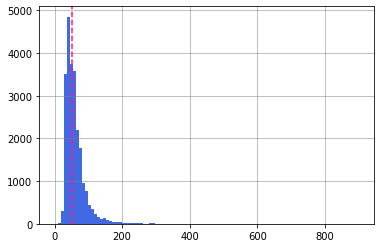

In [131]:
explorer.histogram(df.total_area, 100, 0, 900)

распределение положительно и несимметрично - распределение Пуассона с длинным хвостом.

- построим диаграмму ящик с усами, чтобы посмотреть наличие выбросов.

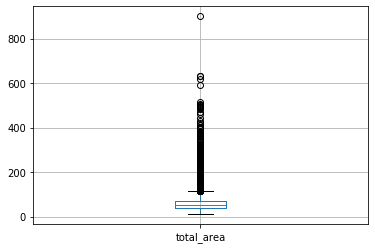

In [132]:
df.boxplot('total_area')

Видно, что есть выбросы, и многие почти до 500 квадратных метров. Изменим масштаб графика.

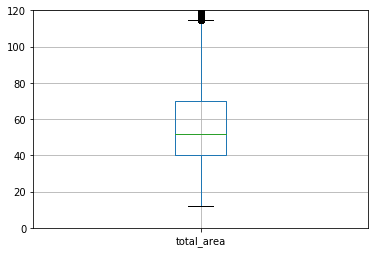

In [133]:
plt.ylim(0, 120)
df.boxplot('total_area')

Нижний «ус» упирается в 12, минимальное значение. Верхний заканчивается около 118 метров — это 1.5 межквартильного размаха, добавленного к 3-му квартилю. Это ориентировочная граница нормального размаха. **Более высокие значения сливаются в единую жирную линию: выбросов очень много.**

In [134]:
df.total_area.describe()

count    23659.000000
mean        60.357880
std         35.677522
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

И несмотря выбросы - медиана и среднее хотя и различаются, но все же не радикально. **Нужно "отрезать хвост" - значения превышающие 118 метров.**

In [135]:
df_normalized = df.query('total_area < 125')

Посмотрим как выглядят значения после удаления выбросов

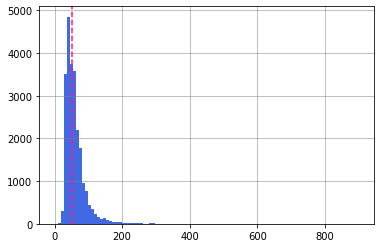

In [136]:
explorer.histogram(df.total_area, 100, 0, 900)

**2) Цена**

- построим гистограмму, чтобы проверить распределение:

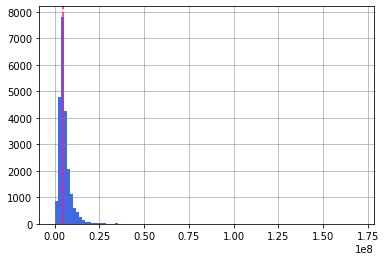

In [137]:
explorer.histogram(df_normalized.last_price, 100, 0, 170000000)

распределение положительно и несимметрично с длинным хвостом.

- построим диаграмму ящик с усами, чтобы посмотреть наличие выбросов

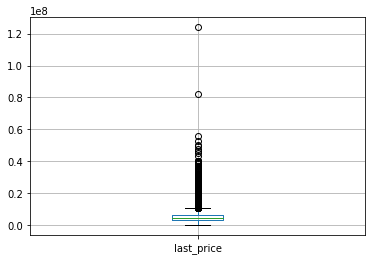

In [138]:
df_normalized.boxplot('last_price')

Есть выбросы, причем много. Изменим масштаб графика.

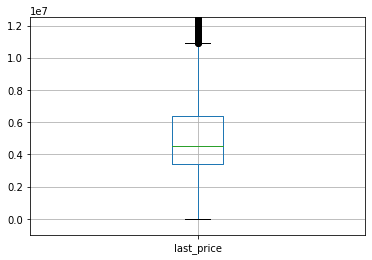

In [139]:
plt.ylim(-1000000, 12500000)
df_normalized.boxplot('last_price')

Минимальное значение где-то в районе нуля. Это и настораживает, и одновременно нормально: редь идет о миллионах. Верхний заканчивается около 11 000 000 миллионов. **Выбросов много и они очевидно влияют на среднее, принимая во внимание как ведет себя на графике медиана.**

**Примем за верхнюю границу цену в 15 миллионов**. Далее значения редкие и это не приведет к большой потере данных.

In [140]:
df_normalized = df_normalized.query('last_price < 15000000')

Посмотрим как выглядят значения после удаления выбросов

In [141]:
#df_normalized.last_price.hist(bins = 100)
pass

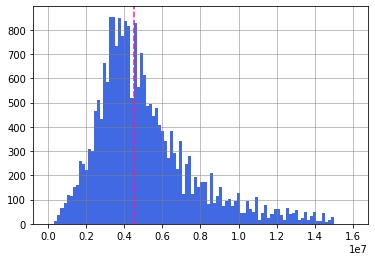

In [142]:
explorer.histogram(df_normalized.last_price, 100, 0, 16000000)

**3) Число комнат**

- построим гистограмму для числа комнат

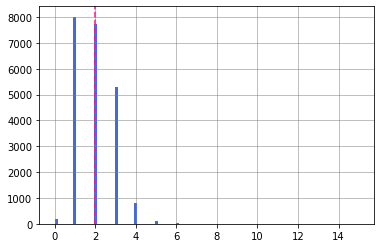

In [143]:
explorer.histogram(df_normalized.rooms, 100, 0, 15)

Есть значения равные 0.Такие данные в датасете отражают студии.

- построим ящик с усами

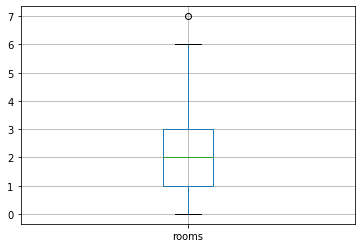

In [144]:
df_normalized.boxplot('rooms')

**Выбросы есть, выбросов мало**. Но вместе с тем, нельзя не отметить, что на среднее сильно влияют значения равные 0. Возможно, использование нулей в датасете - неудачное решение. В любом случае, верхний "ус" в районе 6 комнат. От остальных можно избавиться.

In [145]:
df_normalized = df_normalized.query('rooms < 7')

Проверим на что похоже гистограмма

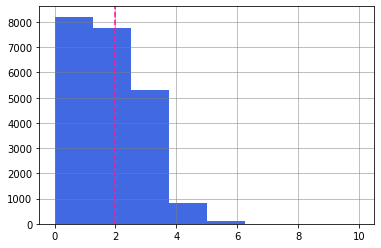

In [146]:
explorer.histogram(df_normalized.rooms, 8, 0, 10)

**4) Высота потолков**

- построим гистрограмму для показателя

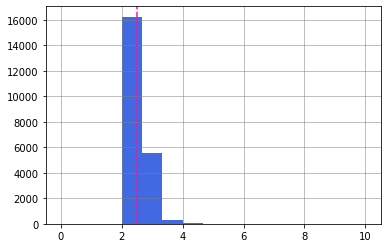

In [147]:
explorer.histogram(df_normalized.ceiling_height, 15, 0, 10)

- построим ящик с усами

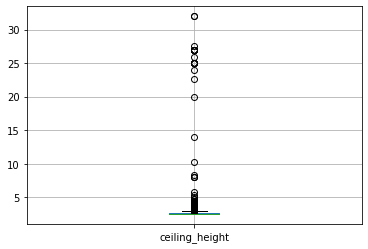

In [148]:
df_normalized.boxplot('ceiling_height')

**Выбросов много. Изменим масштаб графика.**

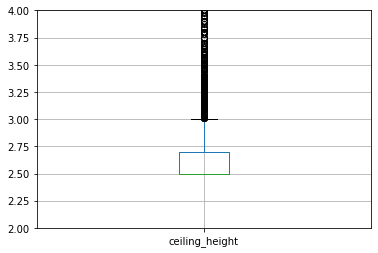

In [149]:
plt.ylim(2, 4)
df_normalized.boxplot('ceiling_height')

Нижний ус отсутствует, медиана и нмижнее значение на 2.5 метрах - результат замены и соответствие действительному положению вещей. Верхний "ус" упирается в высоту 3 метров. **Далее работаем со срезом со значениями ниже 3 метров.**

In [150]:
df_normalized = df_normalized.query('ceiling_height < 4')

Посмотрим как выглядит распределения после удаления выбросов

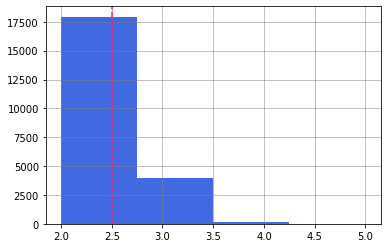

In [151]:
explorer.histogram(df_normalized.ceiling_height, 4, 2, 5)

Распределение Пуассона.

**4) Время продажи**

- Построим гистограмму для столбца days_exposition

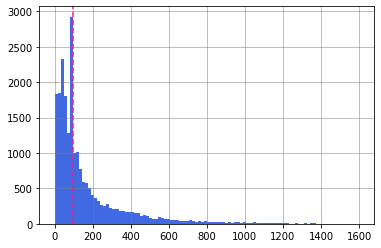

In [152]:
explorer.histogram(df_normalized.days_exposition, 100, 0, 1600)

Положительное и нессиметричное распределение. 

- Построим диаграмму ящик с усами

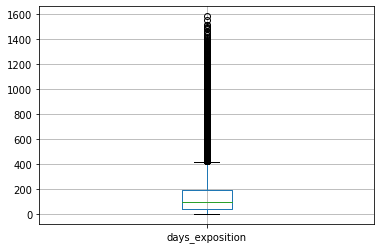

In [153]:
df_normalized.boxplot('days_exposition')

Множественные выбросы. Увеличим масштаб.

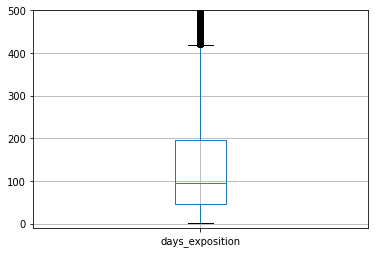

In [154]:
plt.ylim(-10, 500)
df_normalized.boxplot('days_exposition')

Нижняя граница упирается в значение около нуля: это вполне реально, если взять в расчет, что есть квартиры, которые продаются сразу. Верхняя граница лежит в районе 420 дней. Плюс, судя по медиане, выбросы сильно искажают выборку. Избавимся от них.

In [155]:
df_normalized = df_normalized.query('days_exposition < 430')

Построим гистограмму<font>

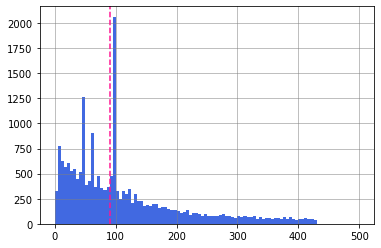

In [156]:
explorer.histogram(df_normalized.days_exposition, 100, 0, 500)

### 2. Проверим сколько строк потеряно в результате очистки данных и устранения выбросов

**При очистке данных основным принципом было максимальное сохранение и восполнение данных. После очистки из 23 699 строк удалось сохранить 23 645 строк с самыми главными показателями. Выведем общую информацию о датасете после устранения выбросов.**

In [157]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20020 entries, 0 to 23698
Data columns (total 28 columns):
total_images               20020 non-null int64
last_price                 20020 non-null int64
total_area                 20020 non-null float64
first_day_exposition       20020 non-null datetime64[ns]
rooms                      20020 non-null int64
ceiling_height             20020 non-null float64
floors_total               20020 non-null int64
living_area                20020 non-null float64
floor                      20020 non-null int64
is_apartment               20020 non-null bool
studio                     20020 non-null bool
open_plan                  20020 non-null bool
kitchen_area               20020 non-null float64
balcony                    20020 non-null int64
locality_name              20020 non-null object
airports_nearest           20020 non-null float64
citycenters_nearest        20020 non-null float64
parks_around3000           20020 non-null float64
ponds_

В датасете **20022 строки**</font>. Таким образом, в результате устранения выбросов **были устранены еще 3 623 строки</font>**.

Следовательно, в результате очистки данных и устранения выбросов **была удалена 3 677‬ строк**</font>, что составляет всего **16 % от выборки.**

### 3. Изучение времени продажи квариры

**С помощью метода describe() выведем основную описательную статистику в отношении столбца days_exposition**

In [158]:
df_normalized.days_exposition.describe()

count    20020.000000
mean       112.325674
std         97.027597
min          1.000000
25%         45.000000
50%         91.000000
75%        149.000000
max        429.000000
Name: days_exposition, dtype: float64

**Среднее** время продажи - **112 дней**, что несильно отличается от **медианного** значения в **91**. Построим гистограмму.

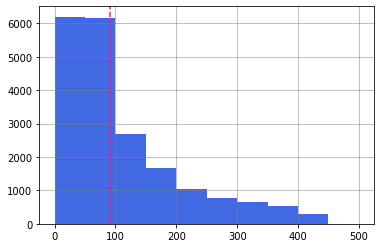

In [159]:
explorer.histogram(df_normalized.days_exposition, 10, 0, 500)

На графике видно, что большая часть квартир продаются менее чем за четыре месяца.

**Половина всех квартир продается в период от 45 (q1) до 149 (q3) дня, то есть за 138 дней, больше четырех месяцев. В случае, если квартира продалась быстрее 45 дней - это довольно быстро, а если больше 149 - то у продавца явно возникли проблемы с продажей.**

### 4. Проверка корреляции между стоимостью квартиры и различными факторами

**1) Методом .corr() выведем коэффициенты корреляции**

In [160]:
explorer.sorted_corr(df_normalized, 'last_price').style.apply(explorer.highlight_sorted_corr)

,last_price
last_price,1
total_area,0.731647
price_per_square,0.648731
living_area,0.606791
kitchen_area,0.534576
rooms,0.45783
ceiling_height,0.361482
airports_nearest,0.314128
ponds_around3000,0.280212
parks_around3000,0.255942


**2) Выделим ~~названные~~ самые важные признаки и визуализируем коэффициенты корреляции**

In [161]:
x = df_normalized[['total_area', 'price_per_square', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'airports_nearest', 'ponds_around3000', 'parks_around3000', 'floors_total', 'total_images', 'floor', 'last_price']]

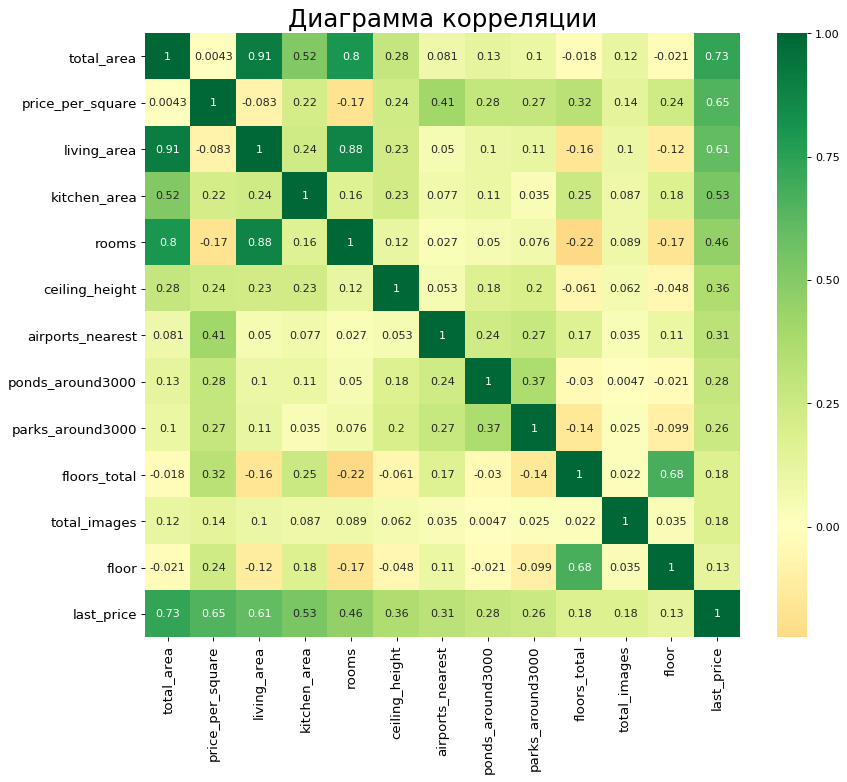

In [162]:
explorer.corr_diagram(x)

**Наибольшая корреляция с ценой усматривается со следющими факторами (фактор - коэффициент выше 0.1):**
    - общая площадь - 0.73,
    - цена за квадратный метр - 0.65
    - жилая площадь - 0.61,
    - площадь кухни - 0.53,
    - количество комнат - 0.46,
    - высота потолков - 0.36,
    - близость аэропорта - 0.31,
    - наличие водоема в пределах трех километров - 0.3,
    - наличие парка в пределах трех километров - 0.26,
    - общая этажность - 0.18,
    - количество фото в объявлении - 0.18,
    - этаж - 0.13.

Ожидаемо, площадь квартиры и отдельные характеристики площади (кухня, жилая площадь, количество комнат и высота потолков) - самые важные факторы, поскольку имеют прямое и непосредственное отношение к недвижимости. Следом идет группа факторов, описывающих местоположние квартиры относительно водоемов, парков и, с оговорками, транспортную доступность. И наконец третий вид факторов - высотность дома и этаж, на котором расположена квартира.

**Удаленность от центра показало слабую корреляцию с ценой - 0.07**.

**Отдельно необходимо отметить цену за кадратный метр - поскольку это дополнительно расчитанный описательный показатель: является выражением соотношения цены и площади квартиры. То есть, показатель расчитывется исходя из одного из потенциально неизвестных - стоимость квартиры. Как следствие - для предсказательной модели этот признак будет губителен, хотя и повысит точность модели (а еще точнее модель будет, если сразу передать ей с цену из выбрки - 100 %).**

- Построим регрессионную линию для расстояния от центра

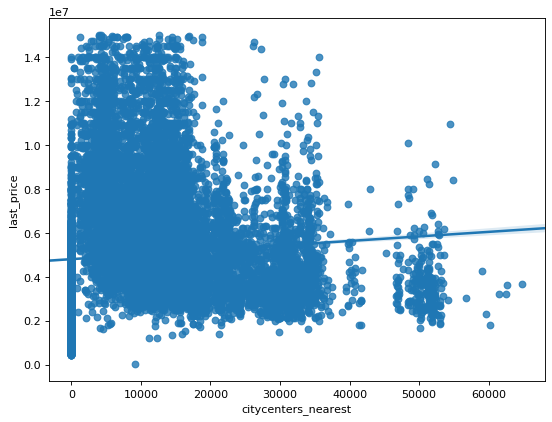

In [163]:
plt.figure(figsize=(8,6), dpi= 80)
sns.regplot(df_normalized.citycenters_nearest, df_normalized.last_price, fit_reg=True)

Несмотря на наклон линии - видно, что чем ближе квартира к центру, тем выше цена. Избавимся от точек на графике

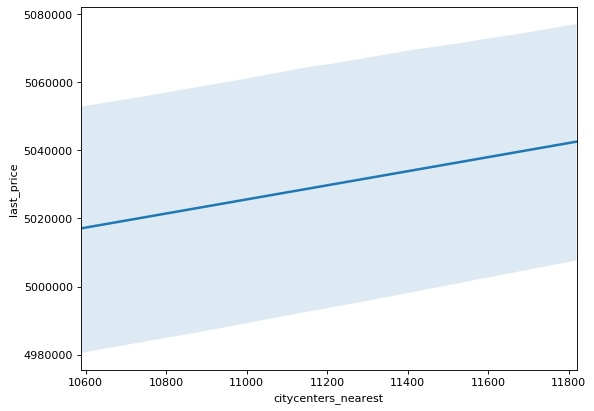

In [164]:
plt.figure(figsize=(8,6), dpi= 80)
sns.regplot(df_normalized.citycenters_nearest, df_normalized.last_price, fit_reg=True, scatter = False)

С помощью regplot </font>

/opt/conda/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


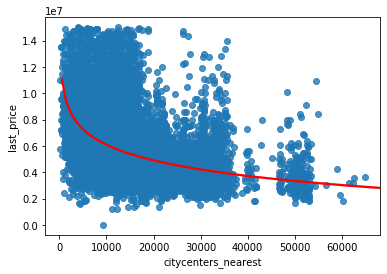

In [165]:
sns.regplot(df_normalized.loc[df_normalized['citycenters_nearest']>0,'citycenters_nearest'], 
            df_normalized.loc[df_normalized['citycenters_nearest']>0,'last_price'], fit_reg=True,logx=True,line_kws={'color':'r'})

Зависимость линейна, но только после логарифмирования

**3) Проверим влияение дня, месяца и года размещения на цену**

Исходя из коэффициентов корреляции влияние дня, месяца и года публикации объявления на цену - ничтожны:
- день - 0.001858,
- месяц - 0.000321,
- год - 0.032449.

Причина по которым год хоть как-то выбивается из того ряда понятна: ежегодно цены растут, рынок недвижимости в этом не исключение. Построим график.

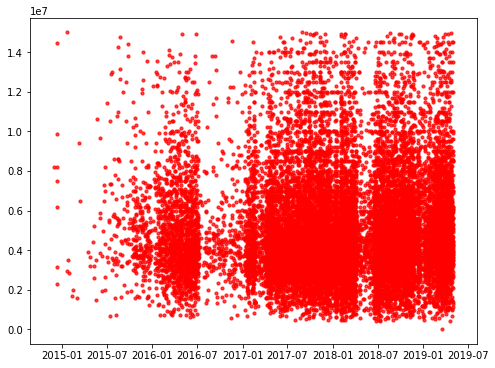

In [166]:
explorer.scatterplot(df_normalized.first_day_exposition, df_normalized.last_price)

График свидетельствует о том, что в выборке больше всего  по годам 2017 - 2018, распределение выглядит равномерным, хотя и есть странные пробелы

Построим графики для:

- **дня**

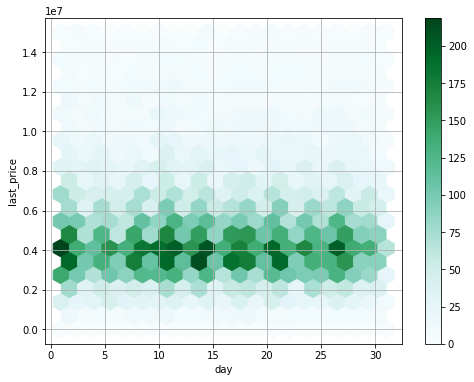

In [167]:
explorer.hexbin(df_normalized, 'day', 'last_price')

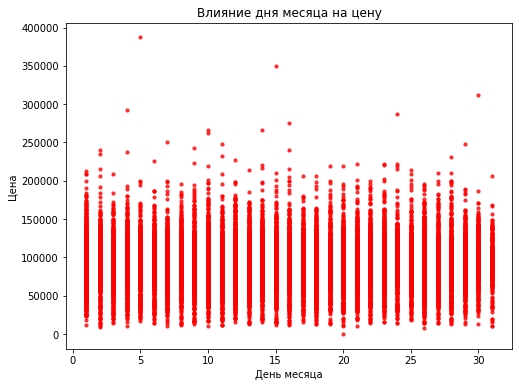

In [168]:
explorer.scatterplot(df_normalized.day, df_normalized.price_per_square, 'День месяца', 'Цена', 'Влияние дня месяца на цену')

- Сгруппируем по дням недели, посчитаем среднюю цену за метр и построим график</font>

In [169]:
explorer.pandahug(df_normalized.groupby('day').price_per_square.mean().sort_values(ascending = False))

,price_per_square
day,
10,96195.526549
30,95691.975000
29,95203.935875
12,95136.592391
4,95020.434932
23,94960.494196
16,94586.801902
15,94463.096403
26,94439.730867


In [170]:
day = explorer.pandahug(df_normalized.groupby('day').price_per_square.mean())

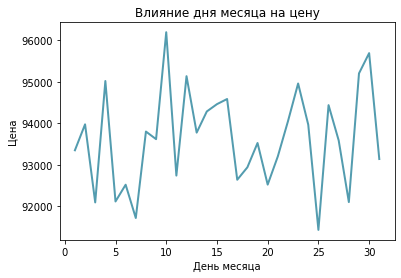

In [171]:
explorer.lineplot(day.index, day.values, 'День месяца', 'Цена', 'Влияние дня месяца на цену')

На графике отчетливо видно, что день недели существенно влияет на цену, указанную в объявлении: на линейный график очень неравномерный. Без визуализации это не так очевидно, поскольку разброс между самой высокой ценой (96 195.53 руб.) и самой низкой (91 435.41) всего - 4 760,12 рублей.</font>

- **месяца**

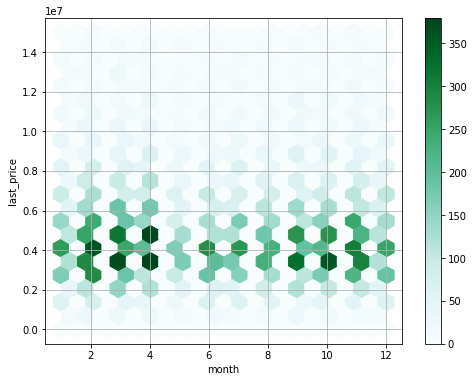

In [172]:
explorer.hexbin(df_normalized, 'month', 'last_price')

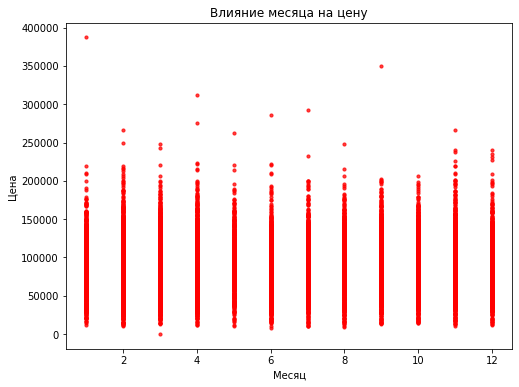

In [173]:
explorer.scatterplot(df_normalized.month, df_normalized.price_per_square, 'Месяц', 'Цена', 'Влияние месяца на цену')

- Сгруппируем по месяцам, посчитаем среднюю цену за метр и построим график</font>

In [174]:
explorer.pandahug(df_normalized.groupby('month').price_per_square.mean().sort_values(ascending = False))

,price_per_square
month,
4,95736.828094
3,94823.793263
8,94698.657143
9,94353.516320
11,94066.827654
7,93676.643460
1,93408.420347
5,93362.867195
2,93042.963628


In [175]:
month = explorer.pandahug(df_normalized.groupby('month').price_per_square.mean())

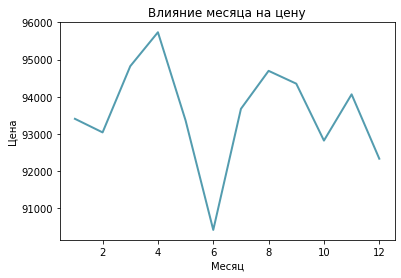

In [176]:
explorer.lineplot(month.index, month.values, 'Месяц', 'Цена', 'Влияние месяца на цену')

Цена колеблется в пределах 5 % весь год. В начале года цена начинает расти и достигает пика в апреле, затем резко падает в мае, достигая дна в июне, а потом также стремительно растет до июля, и уже без столь драматических перепадов  колеблется вплоть до конца года.</font>

- **года**

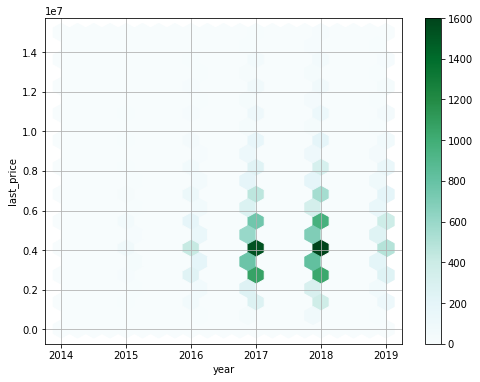

In [177]:
explorer.hexbin(df_normalized, 'year', 'last_price')

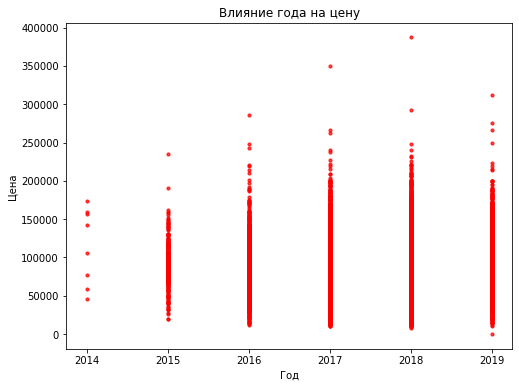

In [178]:
explorer.scatterplot(df_normalized.year, df_normalized.price_per_square, 'Год', 'Цена', 'Влияние года на цену')

- Сгруппируем по месяцам, посчитаем среднюю цену за метр и построим график</font>

In [179]:
explorer.pandahug(df_normalized.groupby('year').price_per_square.mean())

,price_per_square
year,
2014,115019.500000
2015,90714.988406
2016,90950.150871
2017,91488.618914
2018,93782.589744
2019,101381.708989


In [180]:
year = explorer.pandahug(df_normalized.groupby('year').price_per_square.mean())

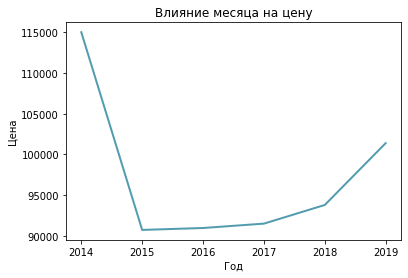

In [181]:
explorer.lineplot(year.index, year.values, 'Год', 'Цена', 'Влияние месяца на цену')

На графике отчетливо видно, как политические и экономические причны повлеки резкое снижение цены на недвижимость в 2014 году. Весь 2014 год цена падала, а затем, достигнув дна в 2015 года, стала сначал медленно, а затем все быстрее рости. Вероятно, тенденция такова, что в абсолютном значении стоимость недвижимости довольно скоро достигнет показателей 2014 года, но нужно принимать во внимание, что рубль изменился и сто пятнадать тысяч за метр в 2014 году вовсе не равны ста пятнадцати тысячам за метр в 2019 году (хотя и денег у потенциальных покупателей стало меньше, как и самих покупателей: словом, это комплексный вопрос, выходящий за рамки исследования).</font>

**4) Проверим как удаленность от центра влияет на стоимость квартиры**

Параметр имеет сущестенное значение только для Петербурга. Сделаем срез из датасета.

In [182]:
df_spb = df_normalized.query('locality_name == "Санкт-Петербург"')

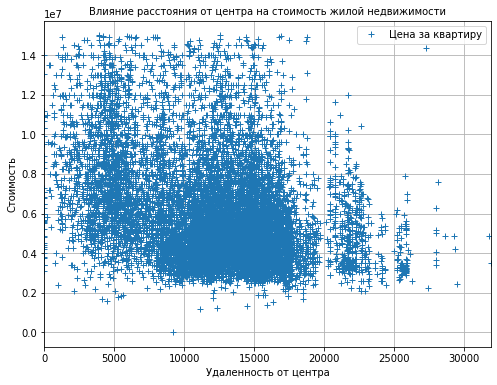

In [183]:
df_spb.plot(x='citycenters_nearest', y='last_price', style='+', figsize=(8, 6), grid=True) 
plt.title('Влияние расстояния от центра на стоимость жилой недвижимости', fontsize=10)
plt.xlabel('Удаленность от центра')
plt.ylabel('Стоимость')
plt.legend(['Цена за квартиру'])

Чем ближе к центру - тем больше значений цены выше среднего. И явно выделяется группа квартир ближе к центру.

**5) Как первый и последний этаж влияют на стоимость квартиры**

Проверим как влияет на стоимость квартир первый и последний этажи. Для этого используем параметр "цена квадратного метра", построим столбчатый график. 

In [184]:
df_normalized.query('floor_categorized != "другой"').pivot_table(values = 'price_per_square', index = 'floor_categorized', aggfunc = 'mean')

,price_per_square
floor_categorized,
первый,80034.147833
последний,85006.453443


In [185]:
df_floors = df_normalized.query('floor_categorized != "другой"').pivot_table(values = 'price_per_square', index = 'floor_categorized', aggfunc = 'mean')

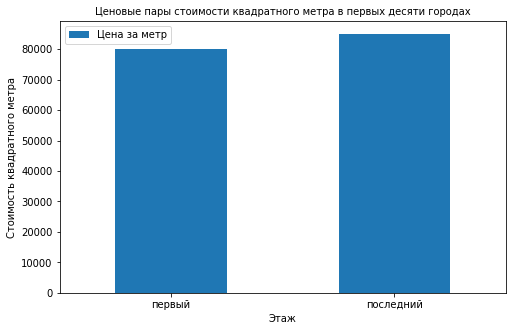

In [186]:
df_floors.plot.bar(rot=0, grid = False, figsize = (8, 5))
plt.title('Ценовые пары стоимости квадратного метра в первых десяти городах', fontsize=10)
plt.xlabel('Этаж')
plt.ylabel('Стоимость квадратного метра')
plt.legend(['Цена за метр'])

Ожидаемо, квартиры на последнем этаже дороже квартир на первом. Это подтверждают и эксперты [Real Estate Investing Group](https://medium.com/@estateinvesting/%D0%BA%D0%B0%D0%BA-%D1%8D%D1%82%D0%B0%D0%B6-%D0%B2%D0%BB%D0%B8%D1%8F%D0%B5%D1%82-%D0%BD%D0%B0-%D1%81%D1%82%D0%BE%D0%B8%D0%BC%D0%BE%D1%81%D1%82%D1%8C-%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80%D1%8B-122b055c8fc4)

**6) Исследуем населенные пункты с самой высокой и низкой стоимостью жилья**

- Сгруппируем датасет по наименованию населенного пункта, выявим населенные пункты с наибольшим числом объявлений

In [187]:
explorer.pandahug(df_normalized.groupby('locality_name').locality_name.count().sort_values(ascending = False).head(10))

,locality_name
locality_name,
Санкт-Петербург,12938
Мурино,543
Кудрово,429
Шушары,406
Всеволожск,351
Колпино,314
Пушкин,313
Парголово,301
Гатчина,271


Петербург лидирует с колоссальным отрывом - 12 938 объявления из 20 022 - 65 %.

- **Посчитаем среднюю цену квадратного метра для этих 10 населённых пунктов**.

Создадим список из данных населенных пунктов

In [188]:
loc_name_list = ['Санкт-Петербург', 'Мурино', 'посёлок Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'деревня Кудрово', 'Выборг']

Сделаем срез, посчитаем среднее с помощью сводной таблицы

In [189]:
top_10_freq = df_normalized.query('locality_name in @loc_name_list').pivot_table(values = 'price_per_square', 
index = 'locality_name', 
aggfunc = 'mean')

Отсортируем результат и округлим значения до двух знаков после запятой

In [190]:
top_10_freq.sort_values('price_per_square', ascending = False, inplace = True)

In [191]:
top_10_freq['price_per_square'] = top_10_freq['price_per_square'].round(2)

Выведем результат со средней стоимостью жилья и визуализируем результат

In [192]:
top_10_freq

,price_per_square
locality_name,
Санкт-Петербург,107326.85
Пушкин,100827.21
Парголово,89902.73
Мурино,86343.69
Колпино,75322.00
Гатчина,69284.41
Всеволожск,67228.17
Выборг,58318.52


Ожидаемо, с некоторым отрывом лидирует Петербург и пригород Петербурга - Пушкин

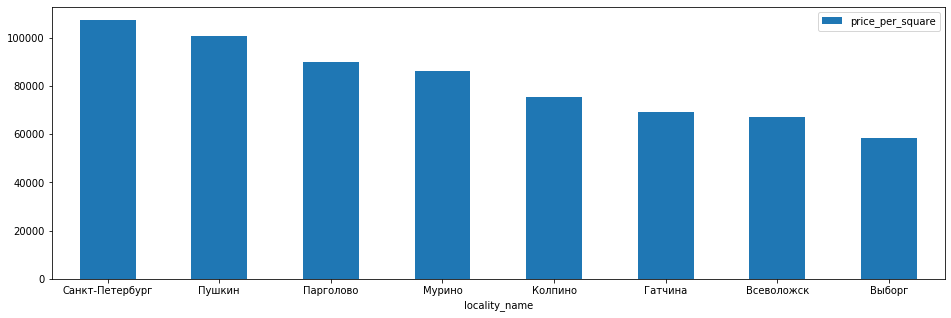

In [193]:
explorer.bar_plotter(top_10_freq)

- **Узнаем 10 населенных пунктов самой дорогой недвижимостью и 10 населенных пунктов с самой дешевой недвижимостью**

Посмотрим на десять самых дорогих населенных пунктов с помощью сводной таблицы, присвоим значение переменной, отсортируем, выведем первые десять строк.

In [194]:
most_exp = df_normalized.pivot_table(values = 'price_per_square', index = 'locality_name', aggfunc='median').sort_values('price_per_square', ascending = False).head(10)

In [195]:
most_exp

,price_per_square
locality_name,
Лисий Нос,113728.0
Санкт-Петербург,103125.0
Сестрорецк,101349.5
Зеленогорск,100000.0
Пушкин,99431.0
Левашово,96997.0
Кудрово,96153.0
Репино,92727.0
Парголово,91328.0


**Лисий Нос лидирует с отрывом - элитарный поселок недалеко от Петербурга.** Визуализируем результат:

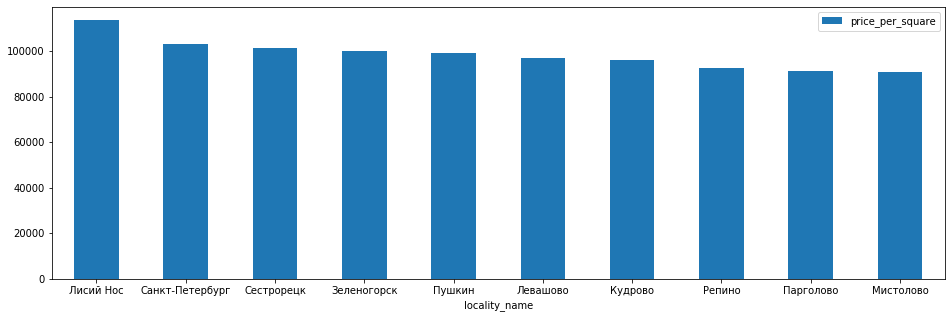

In [196]:
explorer.bar_plotter(most_exp)

Посмотрим на десять самых дешевых населенных пунктов с помощью сводной таблицы, присвоим значение переменной, отсортируем, выведем первые десять строк.

In [197]:
most_cheap = df_normalized.pivot_table(values = 'price_per_square', 
index = 'locality_name', 
aggfunc='median').sort_values('price_per_square', ascending = False).tail(10)

In [198]:
most_cheap

,price_per_square
locality_name,
Житково,14264.0
Ям-Тесово,13711.0
Бор,13157.0
Тёсово-4,12931.0
Малая Романовка,12724.0
Совхозный,12628.5
Выскатка,12335.0
Вахнова Кара,11688.0
Свирь,11481.0


**Зато в поселке Житково и Ставрополье - все еще 2004 год.**

Визуализируем результат

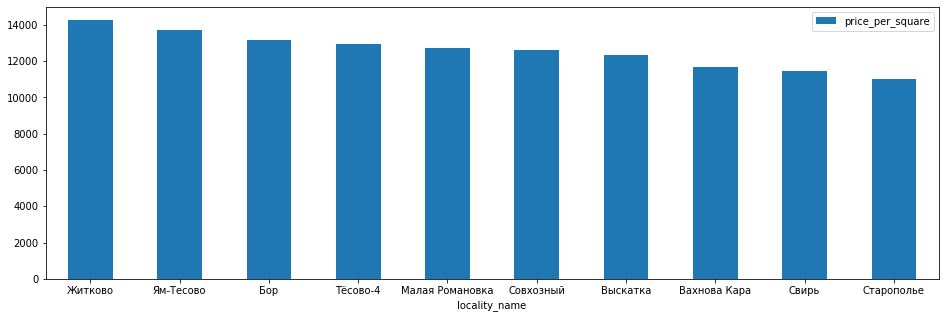

In [199]:
explorer.bar_plotter(most_cheap)

### 5. Исследование корреляции между стоимостью квартиры в центре Петербурга и различными факторами

**1) Выясним, какая область входит в центр Санкт-Петербурга.**

Ранее был сохранен срез по Санкт-Петербургу в переменную df_spb, а также был создан столбец с километражом до центра - city_center_km. Дополним срез столбцом с расчетом средней цены на каждый километр до центра, а затем построим график, чтобы выяснить какая область входит в центр, предполагая, что стоимость квартир в центре заметно выше.

In [200]:
explorer.sorted_corr(df_spb, 'last_price').style.apply(explorer.highlight_sorted_corr)

,last_price
last_price,1
total_area,0.811389
living_area,0.678595
kitchen_area,0.580236
rooms,0.516415
price_per_square,0.487317
ceiling_height,0.351052
ponds_around3000,0.168823
total_images,0.15591
parks_around3000,0.131166


In [201]:
df_spb['mean_price_by_km'] = df_spb.last_price / df_spb.city_center_km

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


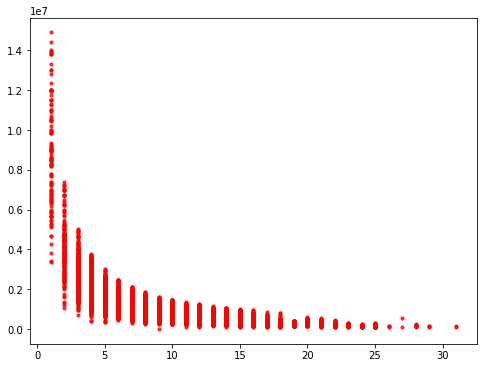

In [202]:
explorer.scatterplot(df_spb.city_center_km, df_spb.mean_price_by_km)

**На графике видно, что в районе трех километров график сильно меняется - это и есть центр. Сохраним срез исходя из расстояния до центра в районе трех километров и исследуем его.**

In [203]:
df_spb_center = df_spb.query('city_center_km < 4')

**2) Исследуем центр Санкт-Петербурга.**

- проверим время продажи в центре города

In [204]:
df_spb_center.days_exposition.describe()

count    718.000000
mean     120.739554
std       96.962705
min        3.000000
25%       60.000000
50%       95.000000
75%      161.000000
max      429.000000
Name: days_exposition, dtype: float64

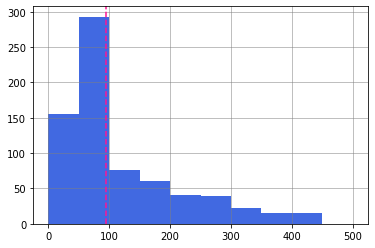

In [205]:
explorer.histogram(df_spb_center.days_exposition, 10, 0, 500)

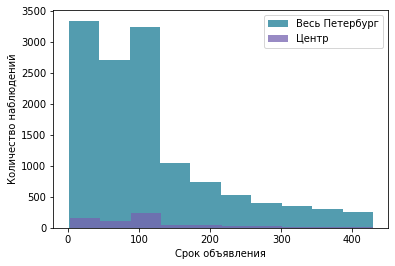

In [206]:
explorer.overlaid_histogram(df_spb.days_exposition, 
df_spb_center.days_exposition, 
10, 
data1_name='Весь Петербург', data2_name='Центр',
x_label='Срок объявления', 
y_label='Количество наблюдений')

С поправкой на количество</font>, в срезе нет глобальных отличий от общей выборки в длительности продажи.

- изучим особоенности показателей общей площади квартиры для центра города

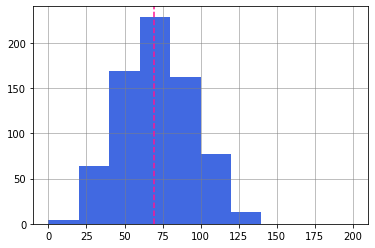

In [207]:
explorer.histogram(df_spb_center.total_area, 10, 0, 200)

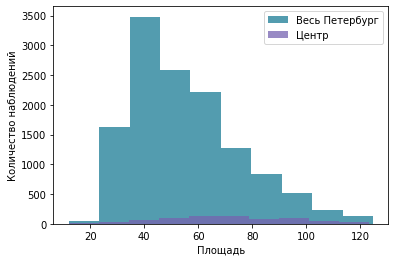

In [208]:
explorer.overlaid_histogram(df_spb.total_area, 
df_spb_center.total_area, 
10, 
data1_name='Весь Петербург', data2_name='Центр',
x_label='Площадь', 
y_label='Количество наблюдений')

В центре города квартиры просторнее относительно всей выборки</font>

- изучим особенности показателей цены на квартиру для центра города

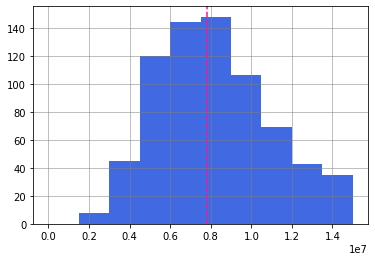

In [209]:
explorer.histogram(df_spb_center.last_price, 10, 0, 15000000)

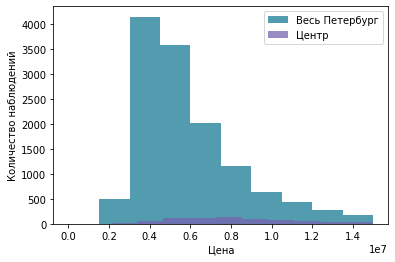

In [210]:
explorer.overlaid_histogram(df_spb.last_price, 
df_spb_center.last_price, 
10, 
data1_name='Весь Петербург', data2_name='Центр',
x_label='Цена', 
y_label='Количество наблюдений')

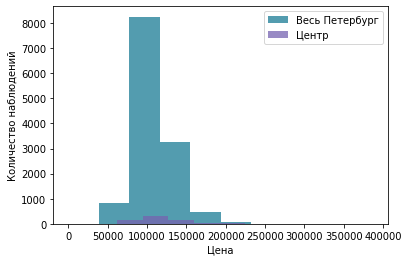

In [211]:
explorer.overlaid_histogram(df_spb.price_per_square, 
df_spb_center.price_per_square, 
10, 
data1_name='Весь Петербург', data2_name='Центр',
x_label='Цена', 
y_label='Количество наблюдений')

В центре города квартиры дороже относительно всей выборки</font>

- изучим особенности показателей количества комнат для центра города

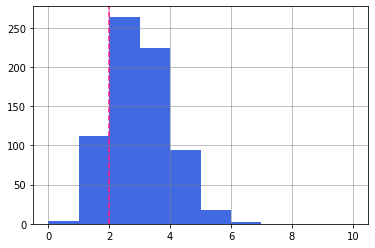

In [212]:
explorer.histogram(df_spb_center.rooms, 10, 0, 10)

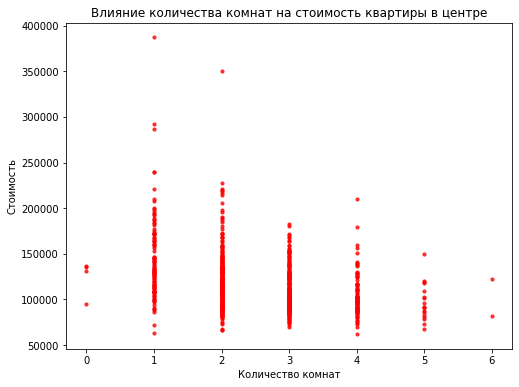

In [213]:
explorer.scatterplot(df_spb_center.rooms, df_spb_center.price_per_square, 'Количество комнат', 'Стоимость', 'Влияние количества комнат на стоимость квартиры в центре')

- изучим особенности показателей высоты потолков для центра города

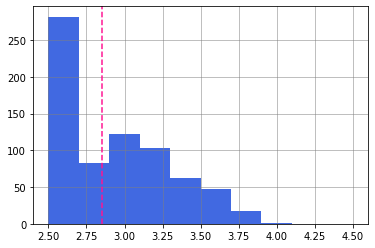

In [214]:
explorer.histogram(df_spb_center.ceiling_height, 10, 2.5, 4.5)

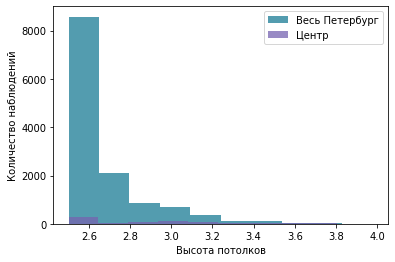

In [215]:
explorer.overlaid_histogram(df_spb.ceiling_height, 
df_spb_center.ceiling_height, 
10, 
data1_name='Весь Петербург', data2_name='Центр',
x_label='Высота потолков', 
y_label='Количество наблюдений')

В центре есть пик в районе трех метров. Потолки выше в квартирах в центе по сравнению с остальной выборкой</font>

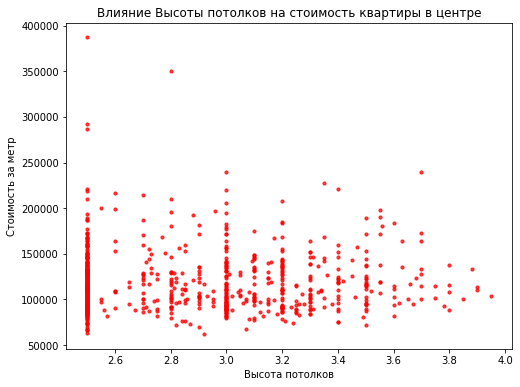

In [216]:
explorer.scatterplot(df_spb_center.ceiling_height, df_spb_center.price_per_square, 'Высота потолков', 'Стоимость за метр', 'Влияние Высоты потолков на стоимость квартиры в центре')

- Проверим влияние даты публикации на стоимость в выборке

Построим общий график

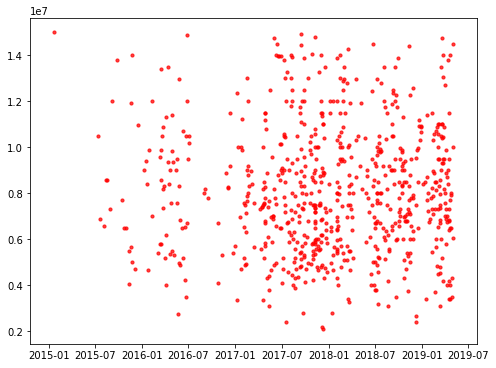

In [217]:
explorer.scatterplot(df_spb_center.first_day_exposition, df_spb_center.last_price)

Выборка небольшая.

Построим графики в отношении центра Петербурга для:

- **дня**

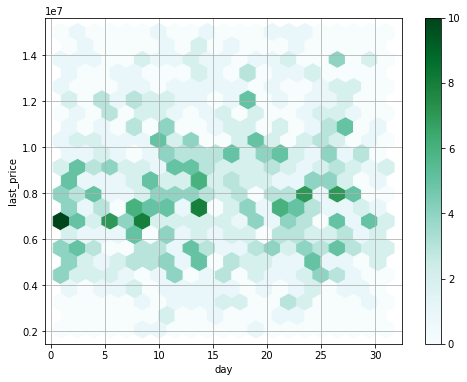

In [218]:
explorer.hexbin(df_spb_center, 'day', 'last_price')

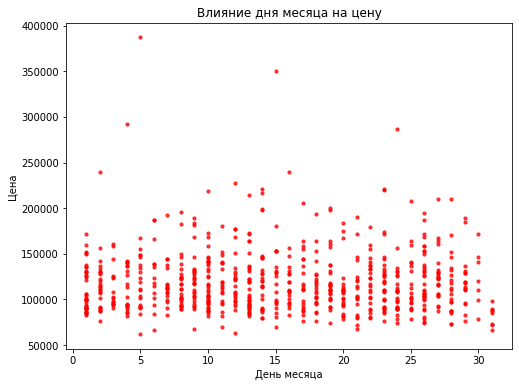

In [219]:
explorer.scatterplot(df_spb_center.day, df_spb_center.price_per_square, 'День месяца', 'Цена', 'Влияние дня месяца на цену')

- Сгруппируем по дням недели, посчитаем среднюю цену за метр и построим график</font>

In [220]:
explorer.pandahug(df_spb_center.groupby('day').price_per_square.mean().sort_values(ascending = False))

,price_per_square
day,
15,128936.800000
5,128632.590909
14,127653.615385
6,125981.285714
27,125925.666667
30,123930.285714
12,123307.208333
19,122272.222222
9,122110.448276


In [221]:
day = explorer.pandahug(df_spb_center.groupby('day').price_per_square.mean())

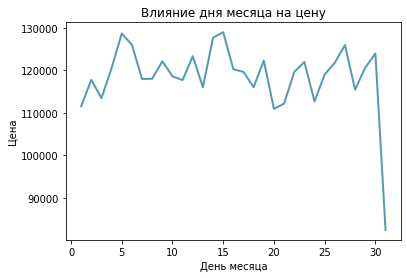

In [222]:
explorer.lineplot(day.index, day.values, 'День месяца', 'Цена', 'Влияние дня месяца на цену')

Резкое падение в последний день месяца

- **месяца**

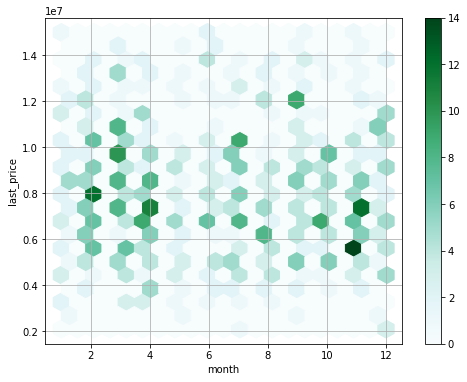

In [223]:
explorer.hexbin(df_spb_center, 'month', 'last_price')

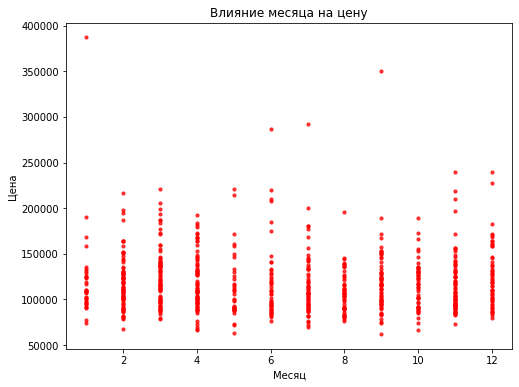

In [224]:
explorer.scatterplot(df_spb_center.month, df_spb_center.price_per_square, 'Месяц', 'Цена', 'Влияние месяца на цену')

- Сгруппируем по месяцам, посчитаем среднюю цену за метр и построим график</font>

In [225]:
explorer.pandahug(df_spb_center.groupby('month').price_per_square.mean().sort_values(ascending = False))

,price_per_square
month,
3,125960.292683
12,125788.685185
1,121361.314286
4,119898.428571
9,119799.384615
6,119665.586957
2,118969.512500
11,116895.355263
10,116569.692308


In [226]:
month = explorer.pandahug(df_spb_center.groupby('month').price_per_square.mean())

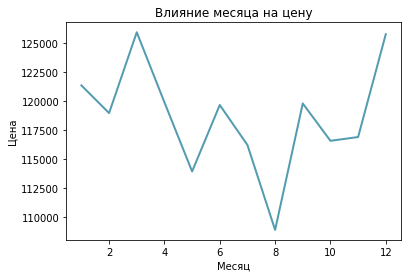

In [227]:
explorer.lineplot(month.index, month.values, 'Месяц', 'Цена', 'Влияние месяца на цену')

Также как и во всей выборке есть колебание от месяца к месяцу: пики в марте и декабре, провал в августе</font>

- **года**

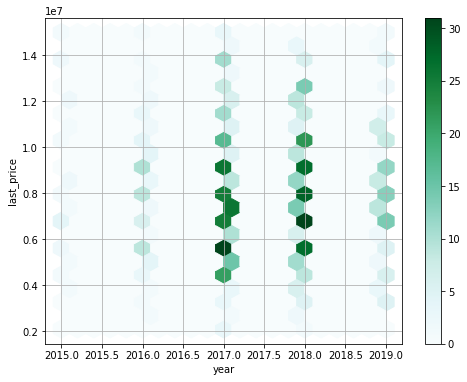

In [228]:
explorer.hexbin(df_spb_center, 'year', 'last_price')

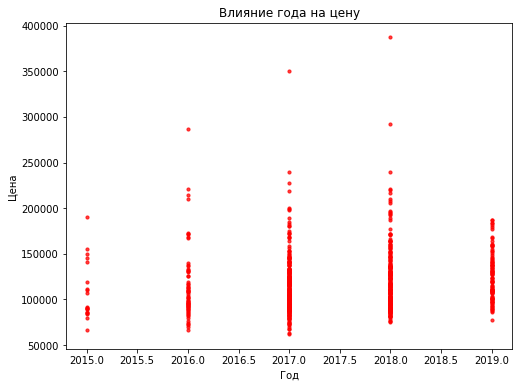

In [229]:
explorer.scatterplot(df_spb_center.year, df_spb_center.price_per_square, 'Год', 'Цена', 'Влияние года на цену')

- Сгруппируем по годам, посчитаем среднюю цену за метр и построим график</font>

In [230]:
explorer.pandahug(df_spb_center.groupby('year').price_per_square.mean())

,price_per_square
year,
2015,108354.500000
2016,114303.347826
2017,115326.455224
2018,122500.666667
2019,124971.924528


In [231]:
year = explorer.pandahug(df_spb_center.groupby('year').price_per_square.mean())

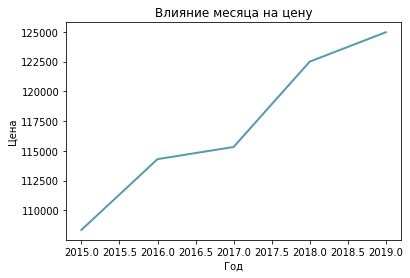

In [232]:
explorer.lineplot(year.index, year.values, 'Год', 'Цена', 'Влияние месяца на цену')

В выборке по центру Петербурга нет данных за 2104 года. с 2015 по 2019 года тенденция общая со всей выборкой - планомерный рост.

- выведем коэффициенты корреляции

In [233]:
explorer.sorted_corr(df_spb_center, 'last_price').style.apply(explorer.highlight_sorted_corr)

,last_price
last_price,1
total_area,0.700977
living_area,0.627328
mean_price_by_km,0.599866
rooms,0.486793
kitchen_area,0.386966
price_per_square,0.337438
total_images,0.173913
ceiling_height,0.136658
airports_nearest,0.124478


Для центра Петербурга удалось выделить следующие признаки с наибольшей корреляцией с ценой:

- общая площадь - 0.70
- площадь кухни - 0.39
- жилая площадь - 0.62
- количество комнат - 0.49
- высота потолков - 0.14
- является ли квартира студией - 0.15 (отрицательная корреляция),
- соотношение площади кухни - 0.15 (отрицательная корреляция),</font> 
- близость аэропорта - 0.12,
- количество фото в объявлении - 0.17.

- выделим названные признаки и визуализируем коэффициенты корреляции

In [234]:
x = df_spb_center[['total_area', 'living_area', 'mean_price_by_km', 'rooms', 'kitchen_area', 'price_per_square', 'total_images', 'ceiling_height', 'airports_nearest', 'kitchen_area_percentage', 'studio', 'last_price']]

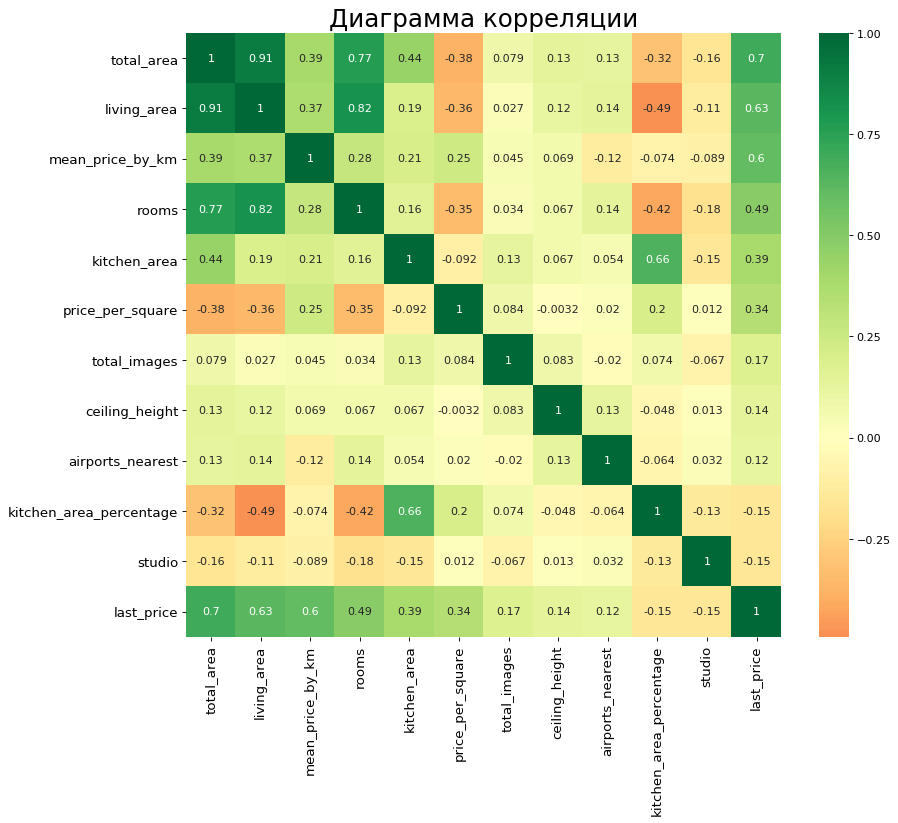

In [235]:
explorer.corr_diagram(x)

**По сравнению с отстальным Петербургом  целом очень слабое влияние на цену оказывает количество парков и водоемов рядом, близость к центру города (поскольку это и так уже центр). Очевидно, в центре города селятся не из-за прудов и парков. Кроме того, есть существеная отрицательная корреляция с тем, является ли квартира студией, а также заметно возросла роль близости к аэропорту.
Есть изменения в корреляции в самых взаимозависимых с ценой характеристиках - с площадью. Для центра города характеристики площад все еще играют меньшую роль, но все же меньше, чем в остальных частях города.**

**3) Построим модель множественной регрессии в отношении недвижимости Санкт-Петербурга**

Для Петербурга удалось выделить следующие признаки с наибольшей корреляцией с ценой:

- общая площадь - 0.81,
- площадь кухни - 0.58,
- жилая площадь - 0.67,
- количество комнат - 0.52,
- высота потолков - 0.35,
- близость к центру города - -0.36 (отрицательная корреляция),
- наличие водоема в пределах трех километров - 0.13,
- наличие парка в пределах трех километров - 0.17,
- общая этажность - 0.18,
- количество фото в объявлении - 0.16.

Средняя цены на километр, и стоимость квадратного метра не могут использоваться для предстказательной модели, поскольку они могут быть выведены только из цены продажи, которую и должна предсказывать модель.

- выделим необходимые характеристики, влияющие на стоимость и сохраним в переменной "х", а столбец со стоимостью сохраним в переменной "y".

In [236]:
explorer.sorted_corr(df_spb, 'last_price').style.apply(explorer.highlight_sorted_corr)

,last_price
last_price,1
total_area,0.811389
living_area,0.678595
kitchen_area,0.580236
mean_price_by_km,0.534965
rooms,0.516415
price_per_square,0.487317
ceiling_height,0.351052
ponds_around3000,0.168823
total_images,0.15591


In [237]:
df_spb.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'citycenters_nearest',
       'parks_around3000', 'ponds_around3000', 'days_exposition',
       'living_area_percentage', 'kitchen_area_percentage', 'price_per_square',
       'floor_categorized', 'day', 'month', 'year', 'city_center_km',
       'mean_price_by_km'],
      dtype='object')

In [238]:
x = df_spb[['total_area', 'living_area', 'kitchen_area', 'rooms', 'ceiling_height', 'ponds_around3000', 'total_images', 'parks_around3000', 'citycenters_nearest']]

In [239]:
y = df_spb[['last_price']]

- разделим выборку на обучающую и тестовую с помощью функции train_test_split в соотношениях 0.8 и 0.2, соответственно; 

In [240]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)

In [241]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

- применяем масштабирование к тренировочным данным:

In [242]:
train_features = scaler.fit_transform(x_train)

- превращаем цену в одномерную матрицу

In [243]:
price_train = np.ravel(y_train)
price_test = np.ravel(y_test)

- применяем масштабирование к тестовым данным:

In [244]:
test_features = scaler.transform(x_test)

- создаем модель линейной регрессии:

In [245]:
mlr = lr()

- обучаем модель, передаем модели тренировочные данные

In [246]:
mlr.fit(train_features, price_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [247]:
mlr.coef_

array([12665297.60267672,  -589006.13503165,  3516727.69053483,
       -3554243.4750232 ,   510501.60919034,   193013.04402118,
        1712287.39224902,   -14693.66132055, -3001262.74134021])

- проверяем модель на тестовой выборке

In [248]:
y_predict = mlr.predict(test_features)

- визуализируем пересечение фактческой стоимости и предсказанной стоимости

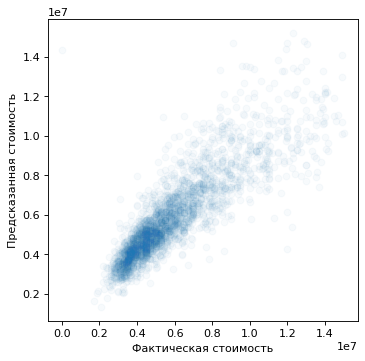

In [249]:
plt.figure(figsize=(5,5), dpi= 80)
plt.scatter(price_test, y_predict, alpha = 0.03)
plt.ylabel('Предсказанная стоимость')
plt.xlabel('Фактическая стоимость')
plt.show()

Выглядит неплохо, попаданий много.

- выберем случайную строку с ценой и пометим соответствующие ей характеристики, чтобы проверить как модель справится

Цена, которую модель будет пытаться угадать

In [250]:
price_train[654]

4500000

Помеченные параметры по которым модель будет предсказывать стоимость, вложим строку в список.

In [251]:
labeled_row = explorer.pandahug(train_features)

In [252]:
labeled = train_features[654]
lreshaped = [labeled]

Передадим помеченную строку модели и выведем на экран предсказанную моделью стоимость.

In [253]:
labeled_price = mlr.predict(lreshaped)

print('\nВероятная стоимость составит ' + str(round(float(labeled_price), 2)) + ' рублей')


Вероятная стоимость составит 4618051.62 рублей


**Расхождение между реальной стоимостью и предсказанной составляет 118 051,62‬ рублей, модель ошиблась на 3 %.**

- проверим точность модели для обучающих и тренировочных данных с помощью метода .score()

Точность для обучающих данных

In [254]:
mlr.score(train_features, price_train)

0.7484726823704646

Точность для тестовых данных

In [255]:
mlr.score(test_features, price_test)

0.7395796644563772

- Выведем метрику SMAPE - cимметричный средний процент отклонения, ошибку прогнозирования

In [256]:
smape = explorer.smape(price_test, y_predict)

Ошибка прогнозирования по метрике SMAPE

In [257]:
smape

7.388529545000917


Следовательно, точность прогноза в процентах по метрике MAPE:

In [258]:
100 - smape

92.61147045499908

- Выведем метрику MAPE - cредний процент отклонения, ошибку прогнозирования

In [259]:
mape = explorer.mape(price_test, y_predict)

Ошибка прогнозирования по метрике MAPE

In [260]:
mape

11.695261078855157

Следовательно, точность прогноза в процентах по метрике MAPE:

In [261]:
100 - mape

88.30473892114485

### Вывод

1. В результате исследовательского анализа данных датасет был проверен на выбросы. Последовательно исследуя параметры площадь, цена, число комнат, высота потоков, время продажи выявлены множественные выбросы в значениях. Было принято решение сократить выборку, чтобы избавиться от выбивающихся значений. 
2. Как следствие, в результате очистки данных и устранения выбросов была удалена 3 677 строк</font>, что составляет всего 16 % от выборки, а сам датасет сократился до 20022 строк</font>.
3. Выводы, полученные в результате исследования:
 - Половина всех квартир продается в период от 45 до 149 дней.
 - При оценке корреляции выявлены самые важные факторы, взаимозависимые с ценой. Самые важные из которых относятся непосредственно к характеристикам недвижимости (кухня, жилая площадь, количество комнат и высота потолков), следом идут характеристики местоположения квартиры, принадлежность к району, местоположение относительно водоемов, парков и, с оговорками, характеризующую транспортную доступность. И наконец третий вид факторов - высотность дома и этаж, на котором расположена квартира.
 - Дополнительно выяснили, что чем ближе квартира к центру - тем дороже, квартиры на последнем этаже дома дороже первых.
 - Существенных зависимостей от дня, месяца и года публикации выявлено не было.
 - Восемьдесят процентов объявлений размещены в отношении недвижимости всего в 10 городах: Санкт-Петербург, Мурино, посёлок Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина, деревня Кудрово, Выборг.
 - Большинство публикаций в выборке - 65 % - о продаже недвижимости в Санкт-Петербурге (12 938, что неудивительно, поскольку Петербург просто больше), а также Мурино (543), Кудрово (429) и Шушарах (406) - районах с активным жилищным строительством, непосредственно примыкающих к Петербургу. Из Ленинградской области - лидирует Всеволожск (351 объявление). 
 - Из названной десятки самая высокая стоимость недвижимости в Петербурге - средняя цена 107 327 рублей за квадратный метр, самая низкая в Выборге - 58 319 рублей за квадратный метр. Но это не лидеры по цене за квадратный метр по всей выборке.
 - Петербург - всего лишь на втором месте, идет следом за поселком Лисий Нос, в который любят банкиры и господрядчики - 113 28 рублей</font> за квадратный метр. Далее в диапазоне от девяносто до ста тысяч рублей за метр располагаются пригороды Петербурга, а замыкает десятку самых дорогих деревня Мистолово в котором идет "активное коттеджное строительство" - 91 113 рублей за метр.
 - Самая дешевая недвижимость в 2004 году и в деревне Старополье - 11 000 рублей за метр, а возглавляет нижнюю десятку поселок Житково - 14 264 рубля за метр.
 - Для исследования был определен, условно центр Петербурга - в радиусе трех километров от центра.
 - Несмотря на то, что в целом общие тенденции для выборки сохраняются, есть и особенности: по сравнению с остальной выборкой, да и с остальным Петербургом очень слабое влияние на цену оказывает количество парков и водоемов рядом, близость к центру города (поскольку это и так уже центр). Очевидно, в центре города селятся не из-за прудов и парков. Кроме того, есть существенная отрицательная корреляция с тем, является ли квартира студией, а также заметно возросла роль близости к аэропорту. Есть изменения в корреляции в самых взаимозависимых с ценой факторах - с площадью. Для центра города характеристики площадь все еще играют меньшую роль, но все же меньше, чем в остальных частях города.
4. Поскольку в целом выборка по Петербургу получилась наполненной, без существенных пропусков, которые нельзя было бы восполнить - была построена предсказательная модель: множественная линейная регрессия, со скорингом 0.74, с ошибкой прогнозирования по метрике MAPE - 11.7 %, по метрике SMAPE - 7.3 %</font>. В случае получения дополнительных характеристик, в первую очередь района города, пригодные для кодировки, точность модели можно было бы повысить.

### 5. Общий вывод

1. Данные со сведениями о цене недвидимости были загружены, очищены, категоризированы и проанализированы.
2. В полученных данных были выявлены множественные пропуски, небольшое количество бессмысленных данных и 0 дубликатов.
3. Наиболее существенной проблемой оказались пропущенные значения в столбцах с данными о расстояниях до различных объктов, которые должны собираться автоматически. Из-за невозможности эффективного восполнения на основе соседних ячеек - от столбов с данными о расстоянии до близжайшего пруда и парка пришлось избавиться. Возможно, ошибка носит системный характер и требуется выяснить причину появления пропущенных значений.
4. Данные полученные от продавцов - могут показаться странными. Данная странность проистекает из их субъективности. Важно то, что люди склонны вести себя шаблонно описывая товар, поэтому следует не оценивать с точки зрения абсолютной истинности внесенные продавцами характеристики, а скорее выявлять тот самый шаблон, который позволит выявлять аномалии и предсказывать конечную цену.
5. В результате исследования выборка очищена от пропусков, выбросов и странных данных, получен концентрированный срез данных с усредненными параметрами.